In [1]:
## Import necessary libraries - should work mostly from BCI_analysis + matplotlib + numpy
import BCI_analysis
from BCI_analysis.pipeline import pipeline_regression
import importlib
importlib.reload(pipeline_regression)
importlib.reload(BCI_analysis)
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

No module named 'cellpose'
cannot use anatomical mode, but otherwise suite2p will run normally


In [2]:
#load multi-session mat files

#multisession_mat_file = os.path.abspath("/home/jupyter/bucket/Data/Calcium_imaging/multi_session_mat/combined_new_old2.mat")
multisession_mat_file = os.path.abspath("/home/jupyter/temp/combined_new_old2.mat")
#multisession_mat_file_behavior = os.path.abspath("/home/jupyter/bucket/Data/Calcium_imaging/multi_session_mat/combined_behavior.mat")
multisession_mat_file_behavior = os.path.abspath("/home/jupyter/temp/combined_behavior.mat")

# print('loading multi-session imaging data...')
multi_session_data = BCI_analysis.io_matlab.read_multisession_mat_2022(multisession_mat_file)
print('loading multi-session behavior data...')
multi_session_behavior_data = BCI_analysis.io_matlab.read_multisession_behavior_mat(multisession_mat_file_behavior)



loading multi-session behavior data...


In [3]:
# using data from .mat file 
from oasis.functions import deconvolve
importlib.reload(BCI_analysis)
dlc_base_dir = os.path.abspath("/home/jupyter/bucket/Data/Behavior_videos/DLC_output/Bergamo-2P-Photostim/")
bpod_path = os.path.abspath("/home/jupyter/bucket/Data/Behavior/BCI_exported/Bergamo-2P-Photostim/")
suite2p_path = os.path.abspath("/home/jupyter/bucket/Data/Calcium_imaging/suite2p/Bergamo-2P-Photostim/")
sessionwise_data_path = os.path.abspath("/home/jupyter/bucket/Data/Calcium_imaging/sessionwise_tba/")
aligned_data_path = os.path.abspath("/home/jupyter/bucket/Data/Calcium_imaging/data_aligned/")
plt_save_path = os.path.abspath("/home/jupyter/Plots/")
face_rhythm_base_dir = '/home/jupyter/bucket/Data/Behavior_videos/FaceRhythm/'
motion_energy_base_dir = os.path.abspath("/home/jupyter/bucket/Data/Behavior_videos/MotionEnergy/Bergamo-2P-Photostim/")
raw_video_path = os.path.abspath("/home/jupyter/bucket/Data/Behavior_videos/raw/Bergamo-2P-Photostim/")

multi_session_dict = {'mouse':[],
                     'session':[],
                      'mat_idx':[],
                     'cn':[],
                     'DLC_aligned':[],
                     'F':[],
                     'trial_end_frames':[],
                     'F_original':[],
                     'trial_start_original':[],
                     'reward_original':[],
                     'photostim_distance':[],
                     'photostim_amplitude':[],
                     'photostim_amplitude_error':[],                      
                     'photostim_group':[],
                     'photostim_cell':[],
                     'F0':[]}
#needed_subject = 'BCI34'
do_deconvolve = False
for mat_session_index in range(len(multi_session_behavior_data['session'])):
    # if multi_session_behavior_data['mouse'][mat_session_index] != needed_subject:
    #     continue
    # try:
    try:
        mouse = multi_session_behavior_data['mouse'][mat_session_index][:3]+'_'+multi_session_behavior_data['mouse'][mat_session_index][3:]
    except:
        print('mouse ID missing, skipping')
        continue
    session = multi_session_behavior_data['session'][mat_session_index]
    camera = "side"
    data = {'F':multi_session_behavior_data['df_closedLoop'][mat_session_index].T,
           'trial_start':multi_session_behavior_data['trial_start'][mat_session_index],
           'reward':multi_session_behavior_data['rew'][mat_session_index],
           'cn':int(multi_session_behavior_data['conditioned_neuron'][mat_session_index].tolist())-1,
           'si':multi_session_behavior_data['dt_si'][mat_session_index].tolist()}

    if do_deconvolve:
        spikes_matrix= []
        for F_trace in data['F']:
            c, s, b_, g_, lam = deconvolve(F_trace, penalty=1) 
            spikes_matrix.append(s)
        data['F'] = np.asarray(spikes_matrix)


    dict_aligned = BCI_analysis.pipeline_align.get_aligned_data(suite2p_path, 
                                                                dlc_base_dir, 
                                                                bpod_path, 
                                                                sessionwise_data_path, 
                                                                aligned_data_path, 
                                                                motion_energy_base_dir,
                                                                raw_video_path,
                                                                mouse=mouse, 
                                                                FOV=None, 
                                                                camera=camera, 
                                                                session=session, 
                                                                sampling='down', 
                                                                functions = ['diff','diff_signed','mean'],
                                                                function_window = 20,  ### important variable for downsampling 1 for facerhythm - 20/200 for DLC
                                                                convolve_tau = 0.7, #.7
                                                                plot = False,
                                                                overwrite=False,
                                                                use_provided_data=True,
                                                                add_motion_energy = False,
                                                                source_data = data,
                                                                face_rhythm_base_dir = face_rhythm_base_dir,
                                                                use_face_rhythm = False,
                                                                match_with_face_rhythm = False)
    DLC_aligned = pd.DataFrame.from_dict(dict_aligned['DLC_aligned'])
    F = np.concatenate(dict_aligned['F_aligned'], axis=1)

    multi_session_dict['mouse'].append(multi_session_behavior_data['mouse'][mat_session_index])
    multi_session_dict['session'].append(multi_session_behavior_data['session'][mat_session_index])
    multi_session_dict['cn'].append(int(multi_session_behavior_data['conditioned_neuron'][mat_session_index].tolist())-1)
    multi_session_dict['mat_idx'].append(mat_session_index)
    multi_session_dict['DLC_aligned'].append(DLC_aligned)
    multi_session_dict['F'].append(F)
    multi_session_dict['trial_end_frames'].append(dict_aligned['trial_start_indices'])
    multi_session_dict['F_original'].append(data['F'])
    multi_session_dict['trial_start_original'].append(data['trial_start'])
    multi_session_dict['reward_original'].append(multi_session_behavior_data['rew'][mat_session_index])
    multi_session_dict['photostim_distance'].append(multi_session_data['x'][mat_session_index])
    multi_session_dict['photostim_amplitude'].append(multi_session_data['y'][mat_session_index])
    multi_session_dict['F0'].append(np.nanmean(np.nanmean(multi_session_data['Fraw'][mat_session_index],0),1))
    multi_session_dict['photostim_amplitude_error'].append(multi_session_data['e'][mat_session_index])
    multi_session_dict['photostim_group'].append(multi_session_data['GRP'][mat_session_index])
    multi_session_dict['photostim_cell'].append(multi_session_data['id'][mat_session_index])

    #break
        
        
    # except:
    #     print('no luck with session {}'.format(mat_session_index))

print(dict_aligned.keys())



/home/jupyter/Scripts/OASIS/oasis/functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


File found at /home/jupyter/bucket/Data/Calcium_imaging/data_aligned/BCI_33/062722-dict_aligned-downsampled.npy
File found at /home/jupyter/bucket/Data/Calcium_imaging/data_aligned/BCI_33/062822-dict_aligned-downsampled.npy
File found at /home/jupyter/bucket/Data/Calcium_imaging/data_aligned/BCI_33/062922-dict_aligned-downsampled.npy
File found at /home/jupyter/bucket/Data/Calcium_imaging/data_aligned/BCI_33/063022-dict_aligned-downsampled.npy
File found at /home/jupyter/bucket/Data/Calcium_imaging/data_aligned/BCI_33/070122-dict_aligned-downsampled.npy
File found at /home/jupyter/bucket/Data/Calcium_imaging/data_aligned/BCI_34/062722-dict_aligned-downsampled.npy
File found at /home/jupyter/bucket/Data/Calcium_imaging/data_aligned/BCI_34/062822-dict_aligned-downsampled.npy
File found at /home/jupyter/bucket/Data/Calcium_imaging/data_aligned/BCI_34/062922-dict_aligned-downsampled.npy
File found at /home/jupyter/bucket/Data/Calcium_imaging/data_aligned/BCI_34/063022-dict_aligned-downsamp

In [301]:
multi_session_dict['F_deconvolved'] = []
for session_i in range(len(multi_session_dict['session'])):
    F_for_rewards = multi_session_dict['F_original'][session_i]
    F_for_rewards = (F_for_rewards- np.nanmin(F_for_rewards,1)[:,np.newaxis])# made non-negative
    spikes_matrix= []
    for F_trace in F_for_rewards: # use the dF/F from kayvon's data
        c, s, b_, g_, lam = deconvolve(F_trace, penalty=1) 
        spikes_matrix.append(s)
    F_for_rewards = np.asarray(spikes_matrix)
    multi_session_dict['F_deconvolved'].append(F_for_rewards)

/tmp/ipykernel_30383/438271813.py:67: RuntimeWarning: invalid value encountered in true_divide
  RSI_before = np.nansum(np.nansum(F_rewardwise_before,0)[:,:trials_for_RSI],1)/np.nansum(np.nansum(F_trialwise_ctrl,0)[:,:trials_for_RSI],1)
/tmp/ipykernel_30383/438271813.py:72: RuntimeWarning: invalid value encountered in true_divide
  RSI_after = np.nansum(np.nansum(F_rewardwise_after,0)[:,:trials_for_RSI],1)/np.nansum(np.nansum(F_trialwise_ctrl,0)[:,:trials_for_RSI],1)
/tmp/ipykernel_30383/438271813.py:67: RuntimeWarning: divide by zero encountered in true_divide
  RSI_before = np.nansum(np.nansum(F_rewardwise_before,0)[:,:trials_for_RSI],1)/np.nansum(np.nansum(F_trialwise_ctrl,0)[:,:trials_for_RSI],1)


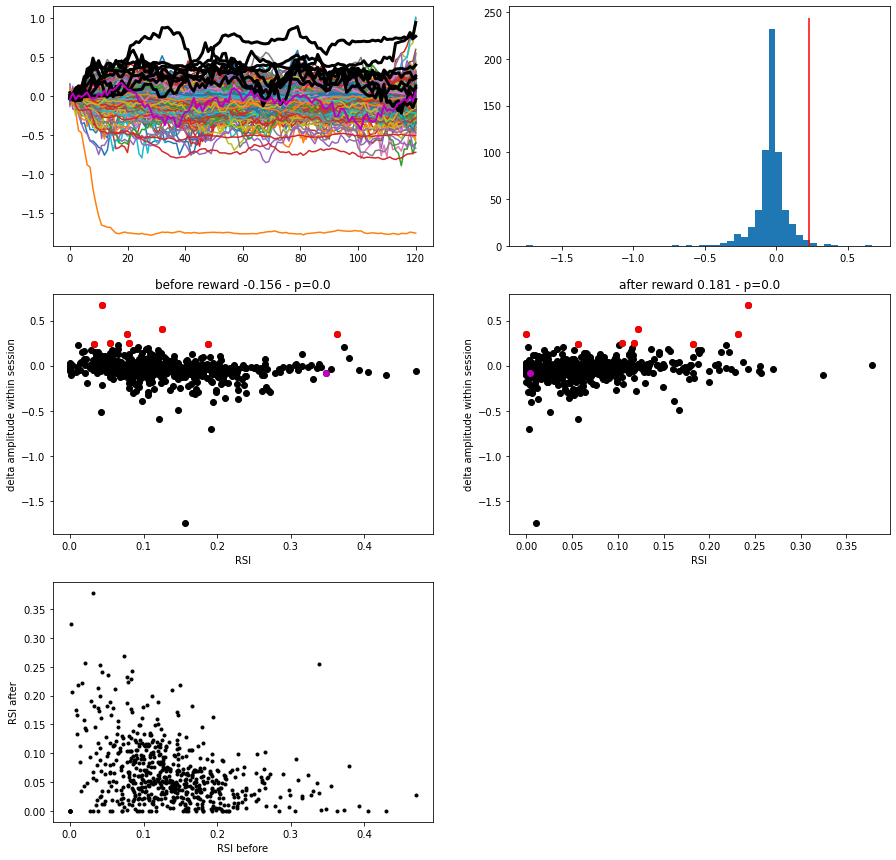

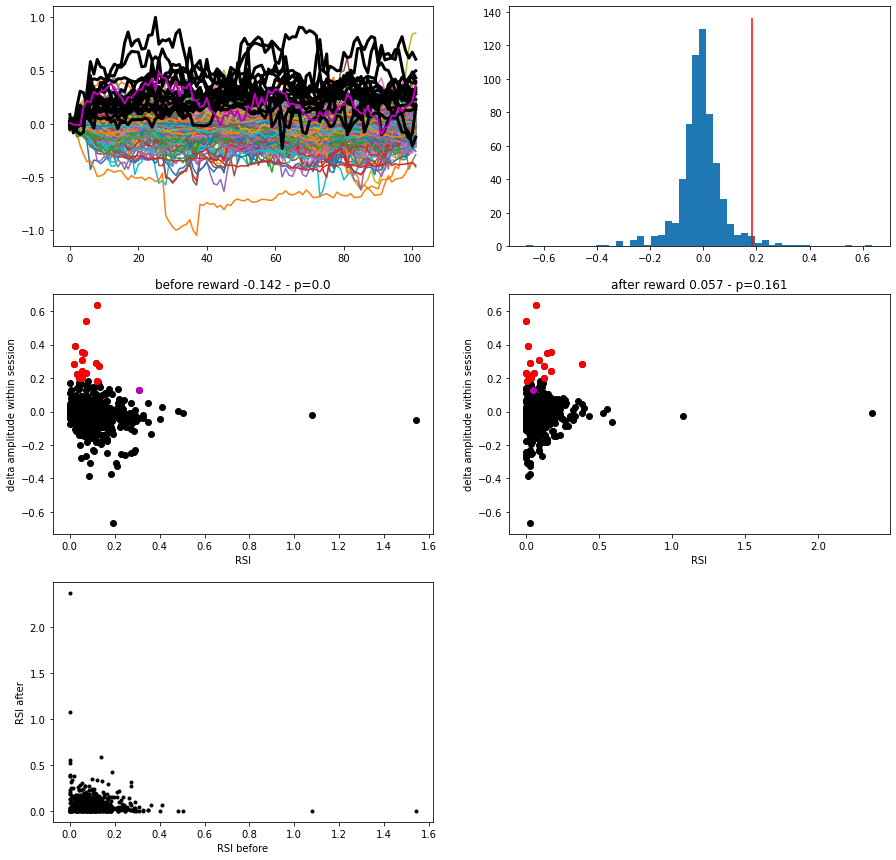

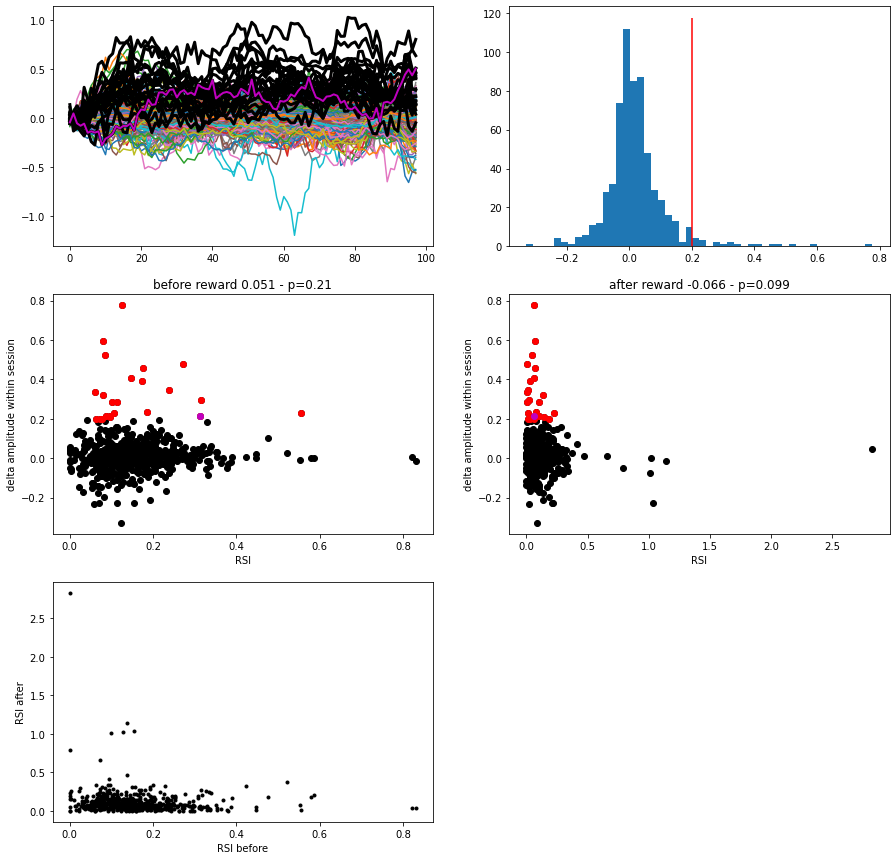

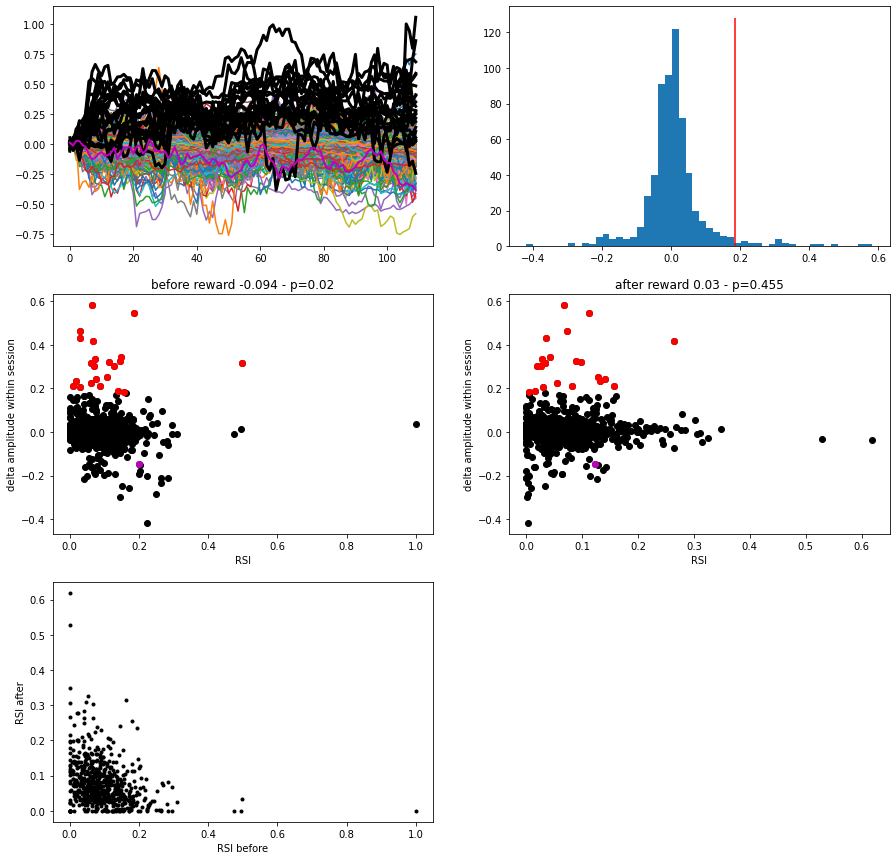

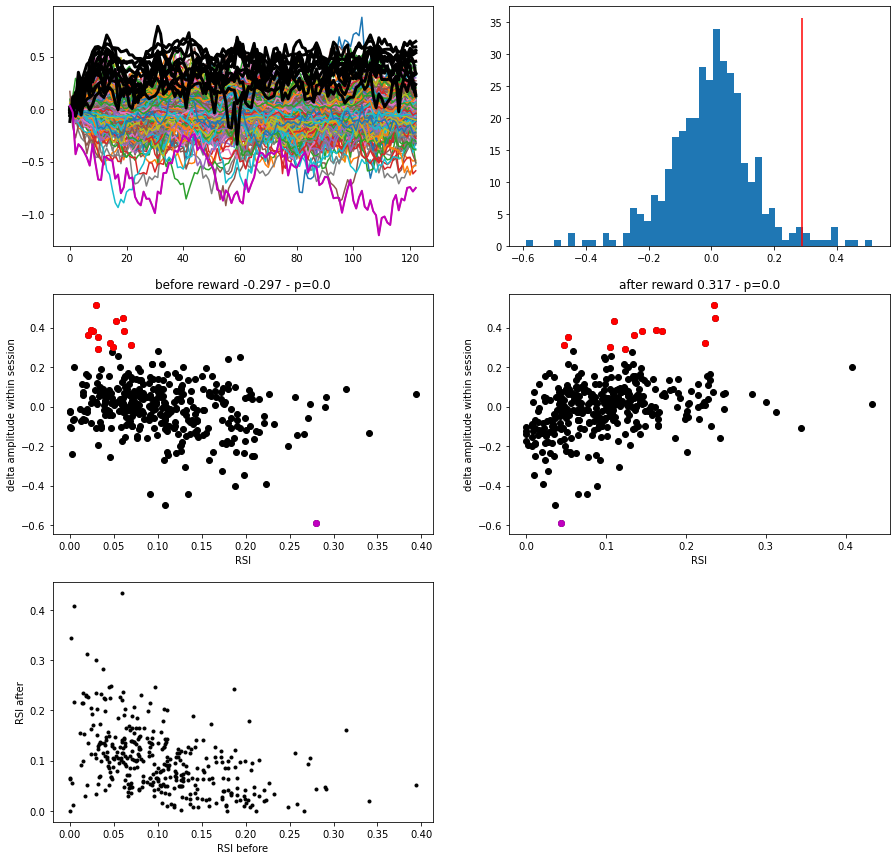

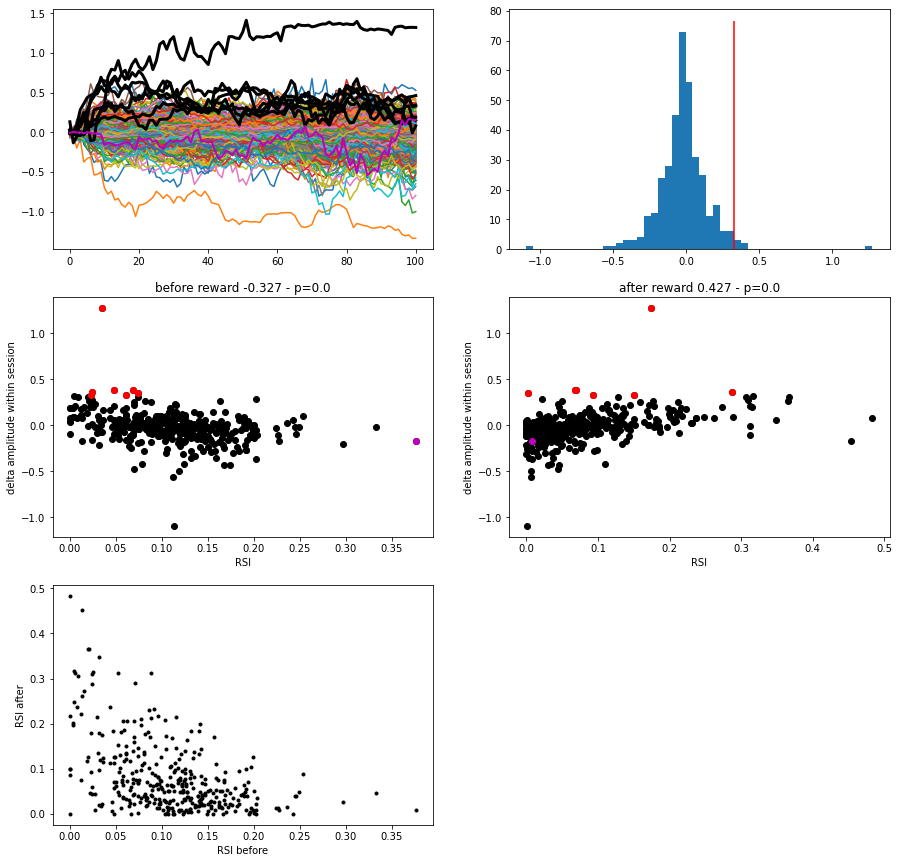

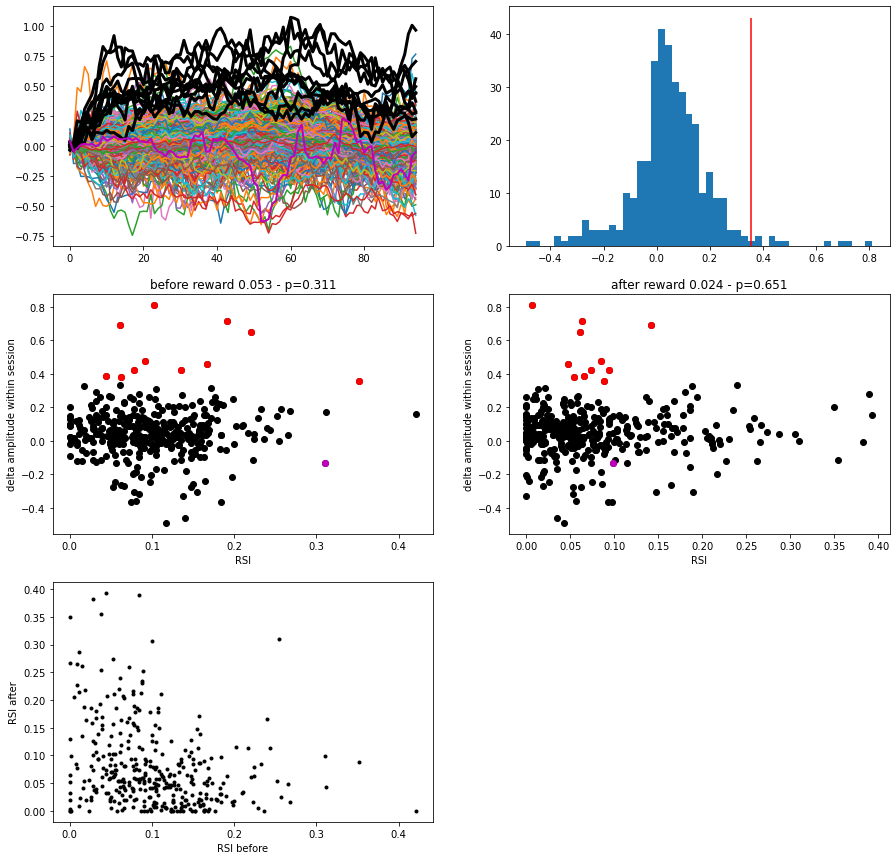

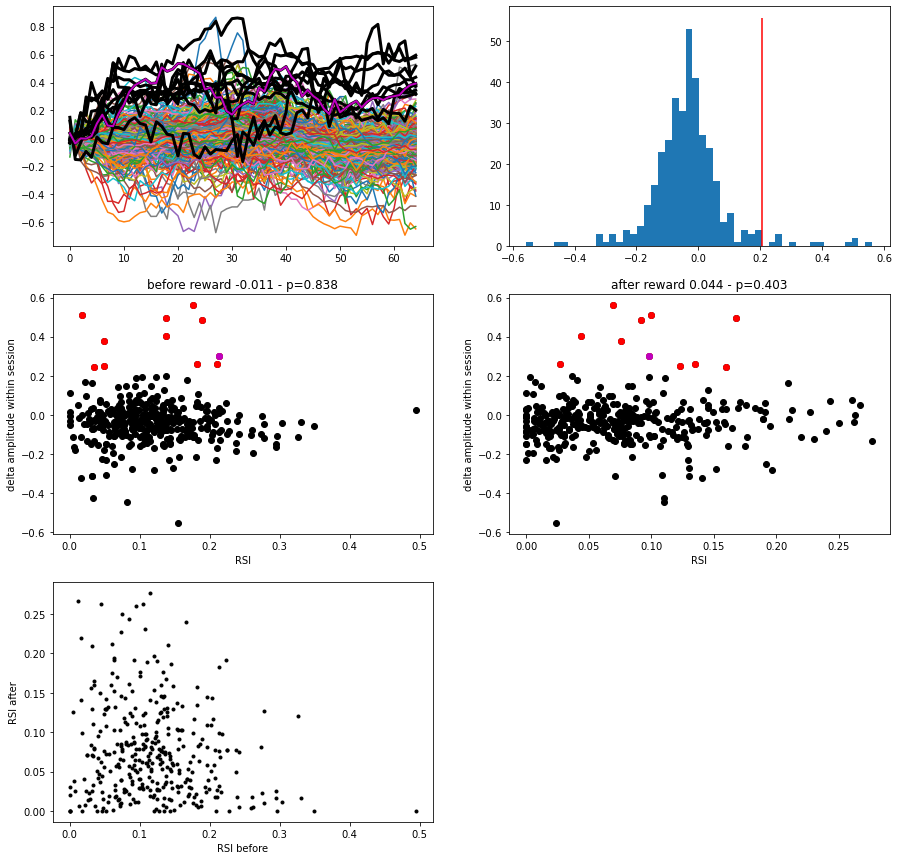

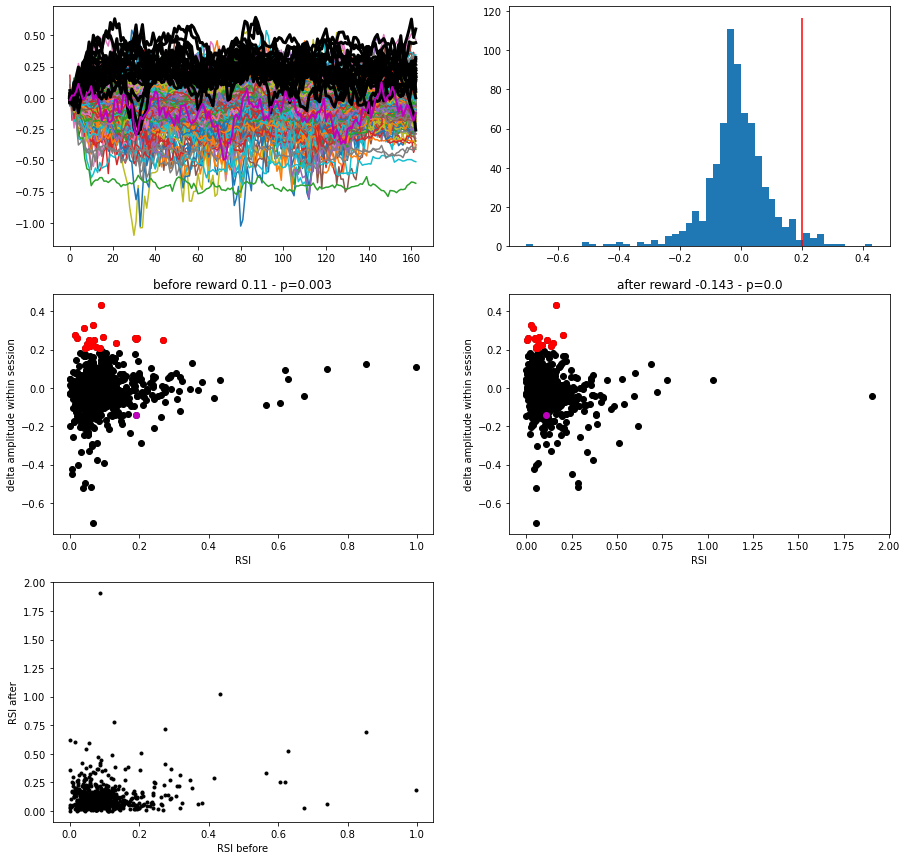

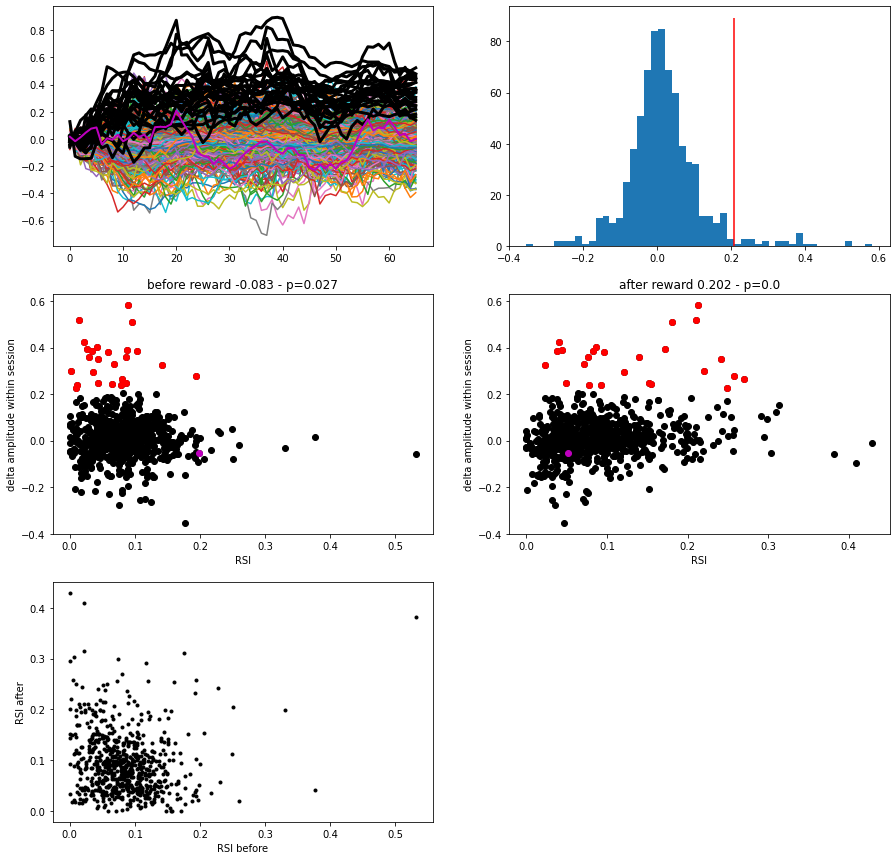

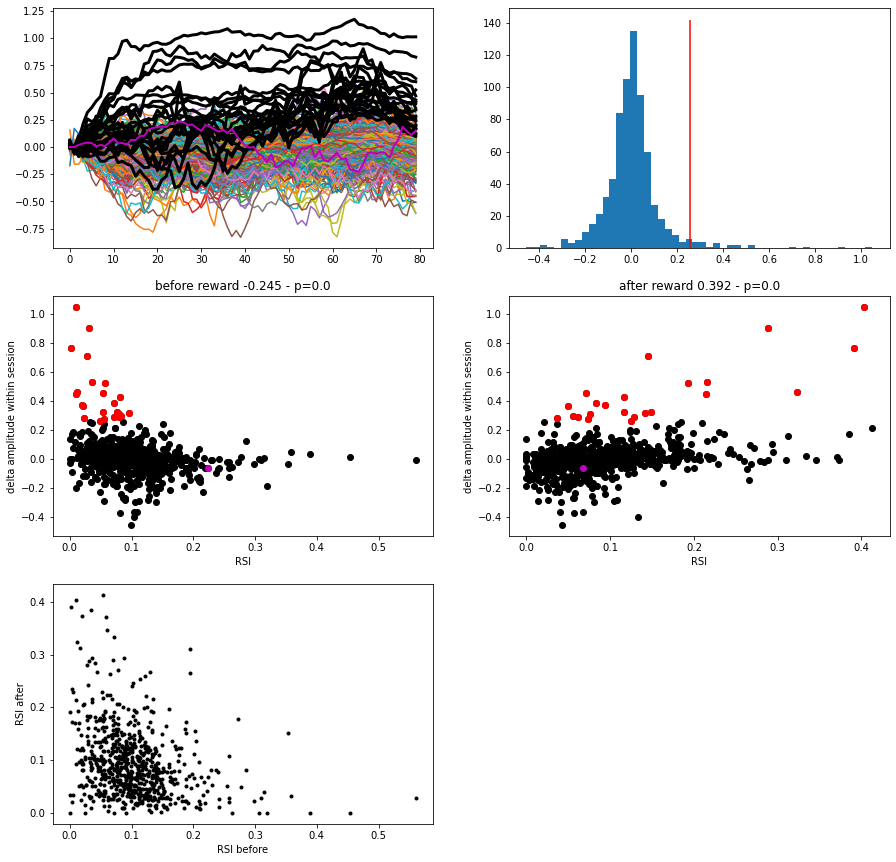

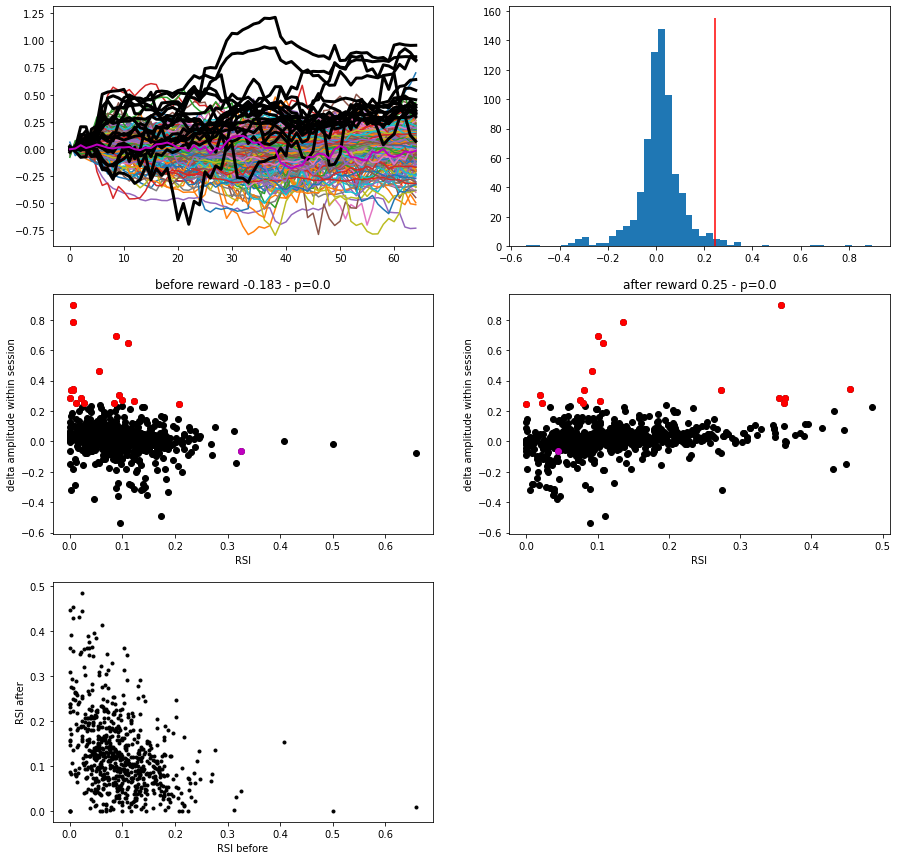

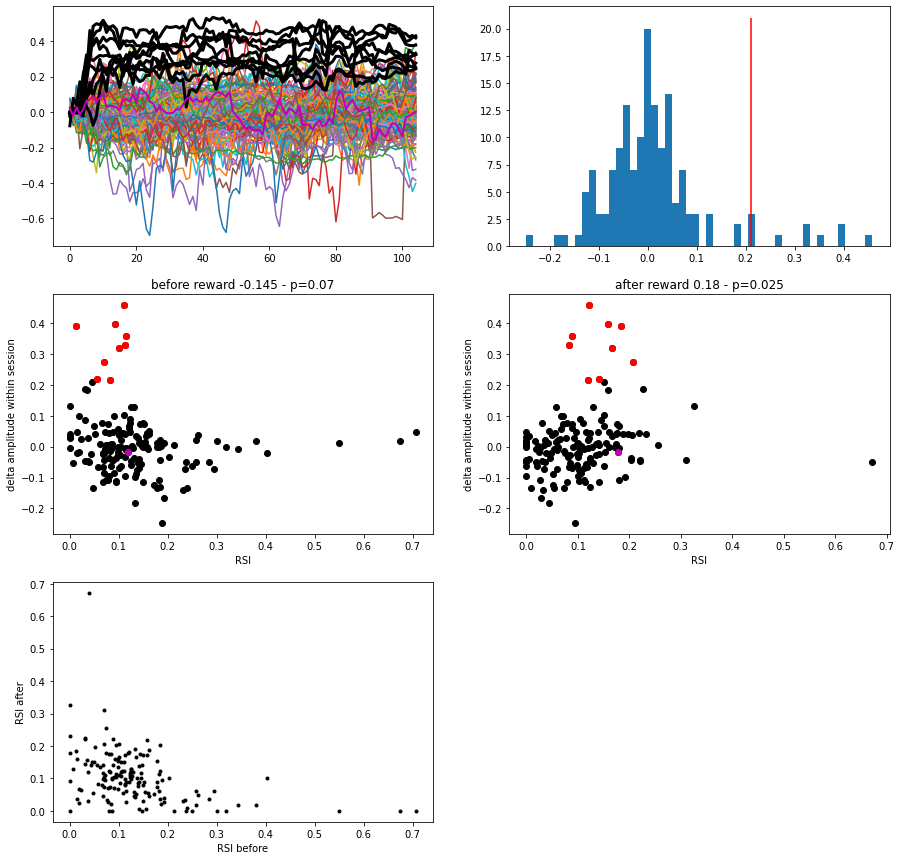

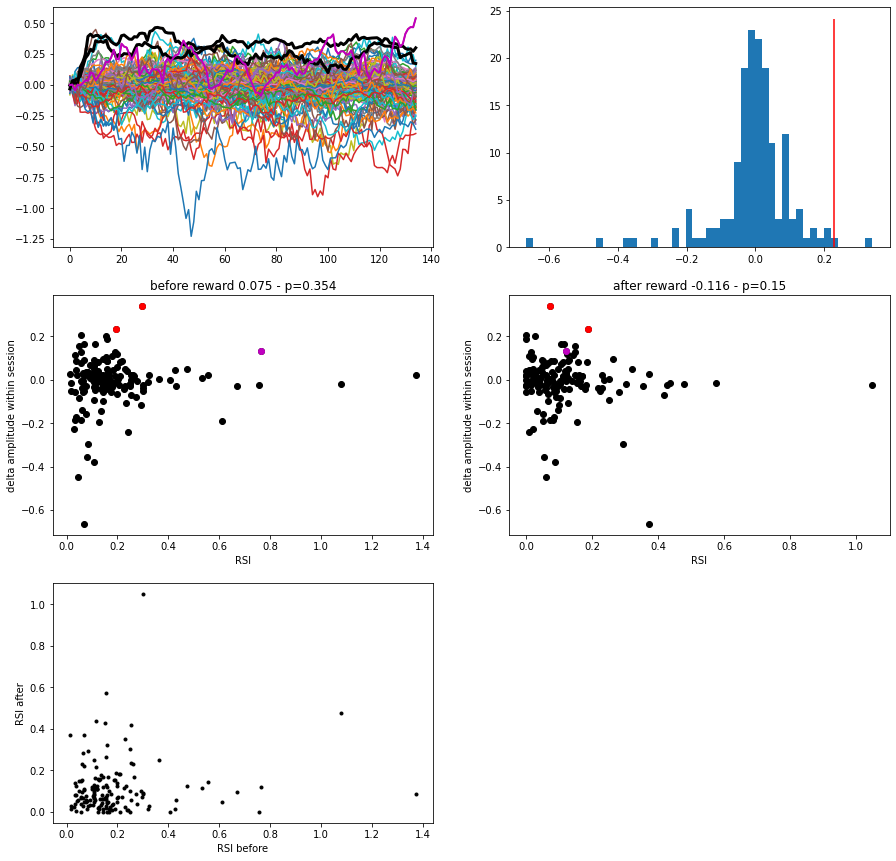

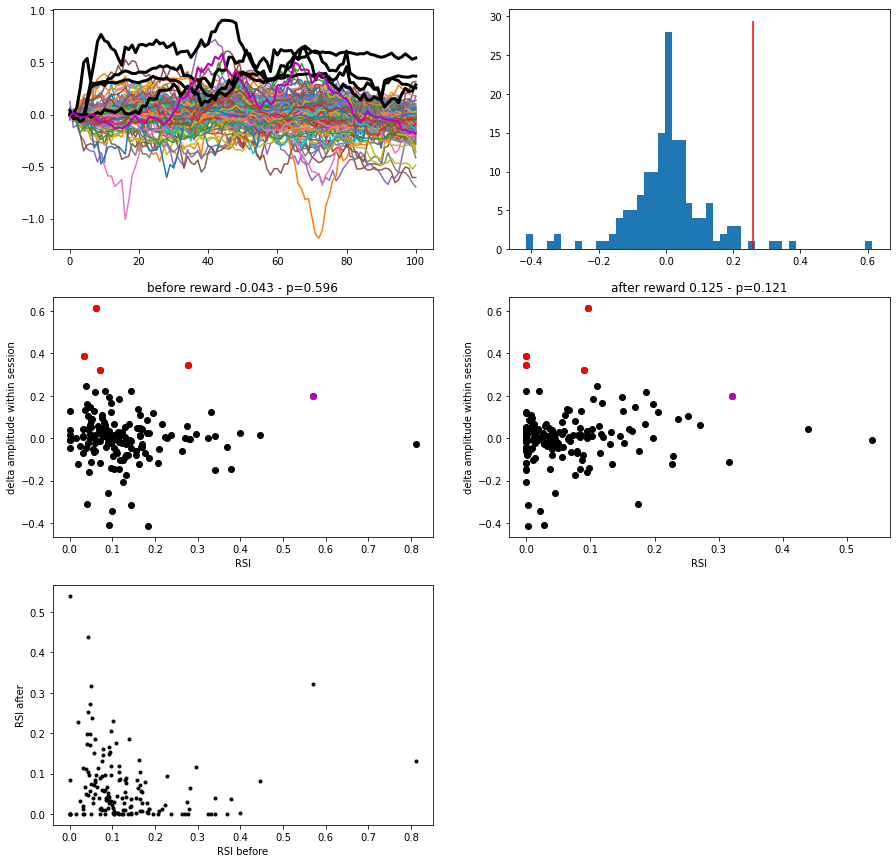

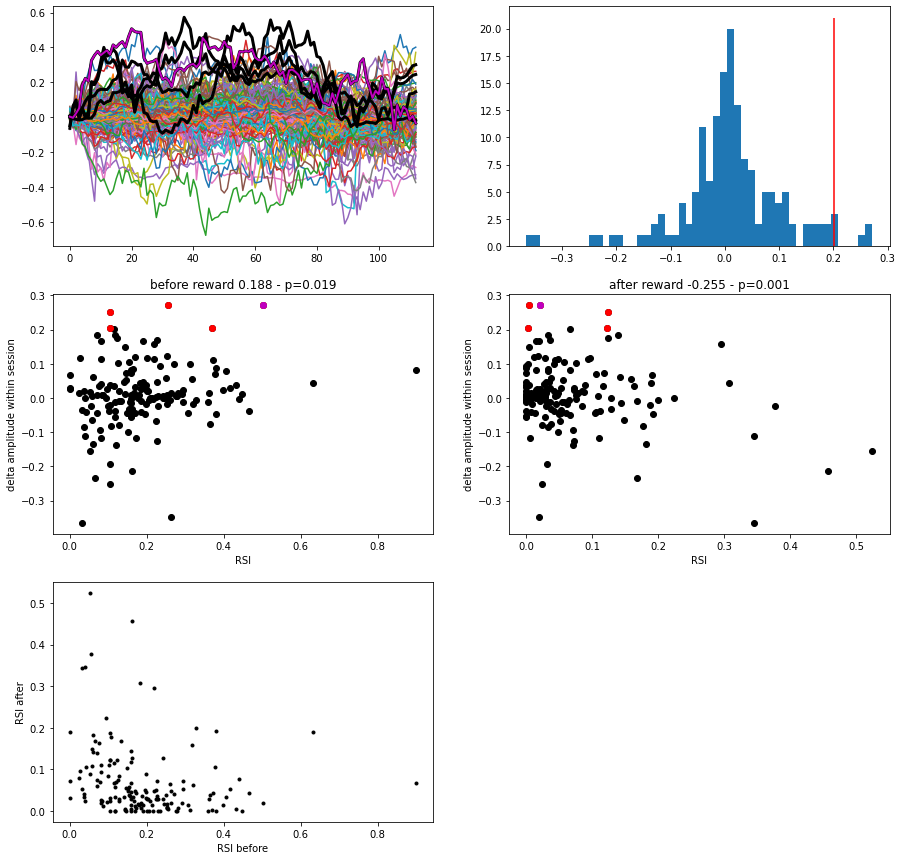

In [312]:
from oasis.functions import deconvolve


filt_window = 10
baseline_len = 2
subtract_baseline = True

trials_for_RSI = 20 # first 20 trials to compute reward synchronization index

r_before_list = []
r_after_list = []
for session_i in range(len(multi_session_dict['session'])):
    if session_i == 1:
        continue# not enough trials
    fig = plt.figure(figsize = [15,15])
    ax1 = fig.add_subplot(3,2,1)
    ax2 = fig.add_subplot(3,2,2)

    
    trial_start_trace = multi_session_dict['trial_start_original'][session_i]
    F_trialwise = BCI_analysis.io_suite2p.sessionwise_to_trialwise_simple(multi_session_dict['F_original'][session_i],
                                                                                trial_start_trace,
                                                                                max_frames=None,
                                                                                frames_after=step_forward, 
                                                                                frames_before=step_back,
                                                                                include_next_trial=True)

    # F_for_rewards = multi_session_dict['F_original'][session_i]
    # F_for_rewards = (F_for_rewards- np.nanmin(F_for_rewards,1)[:,np.newaxis])# made non-negative
    # spikes_matrix= []
    # for F_trace in F_for_rewards: # use the dF/F from kayvon's data
    #     c, s, b_, g_, lam = deconvolve(F_trace, penalty=1) 
    #     spikes_matrix.append(s)
    # F_for_rewards = np.asarray(spikes_matrix)
    F_for_rewards = multi_session_dict['F_deconvolved'][session_i]
    F_rewardwise_after = BCI_analysis.io_suite2p.sessionwise_to_trialwise_simple(F_for_rewards,
                                                                                multi_session_dict['reward_original'][session_i],
                                                                                max_frames=None,
                                                                                frames_after=60 ,
                                                                                frames_before=-40,
                                                                                include_next_trial=False)
    # F_rewardwise = BCI_analysis.io_suite2p.sessionwise_to_trialwise_simple(multi_session_dict['F_original'][session_i],
    #                                                                             trial_start_trace,
    #                                                                             max_frames=None,
    #                                                                             frames_after=20, 
    #                                                                             frames_before=0,
    #                                                                             include_next_trial=True)


    F_rewardwise_before = BCI_analysis.io_suite2p.sessionwise_to_trialwise_simple(F_for_rewards,
                                                                                multi_session_dict['reward_original'][session_i],
                                                                                max_frames=None,
                                                                                frames_after=-20 ,
                                                                                frames_before=40,
                                                                                include_next_trial=False)



    F_trialwise_ctrl = BCI_analysis.io_suite2p.sessionwise_to_trialwise_simple(F_for_rewards,
                                                                                trial_start_trace,
                                                                                max_frames=None,
                                                                                frames_after=1000, 
                                                                                frames_before=0,
                                                                                include_next_trial=False)
    # RSI_before_trial = np.nansum(F_rewardwise_before,0)[:,:trials_for_RSI]/np.nansum(F_trialwise_ctrl,0)[:,:trials_for_RSI]
    # RSI_before = np.nanmean(RSI_before_trial,1)
    RSI_before = np.nansum(np.nansum(F_rewardwise_before,0)[:,:trials_for_RSI],1)/np.nansum(np.nansum(F_trialwise_ctrl,0)[:,:trials_for_RSI],1)
    
    
    # RSI_after_trial = np.nansum(F_rewardwise_after,0)[:,:trials_for_RSI]/np.nansum(F_trialwise_ctrl,0)[:,:trials_for_RSI]
    # RSI_after = np.nanmean(RSI_after_trial,1)
    RSI_after = np.nansum(np.nansum(F_rewardwise_after,0)[:,:trials_for_RSI],1)/np.nansum(np.nansum(F_trialwise_ctrl,0)[:,:trials_for_RSI],1)


    now_amplitudes = (np.nanmean(F_trialwise[step_back:,:,1:],0) - np.nanmean(F_trialwise[:step_back,:,1:],0))
    max_vals = list()
    peak_amplitudes = []
    for cn in np.arange(F_trialwise.shape[1]):
        cn_now_amplitudes = now_amplitudes[cn ,:]

        cn_now_amplitudes_filt = BCI_analysis.plot.plot_utils.rollingfun(cn_now_amplitudes,filt_window)
        if subtract_baseline:
            cn_now_amplitudes_filt -= np.nanmean(cn_now_amplitudes_filt[:baseline_len])
        peak_amplitudes.append(np.nanmean(cn_now_amplitudes_filt[40:100]))
        ax1.plot(cn_now_amplitudes_filt)
        max_vals.append(np.nanmax(cn_now_amplitudes_filt[:50]))
    cn = multi_session_dict['cn'][session_i]
    cn = np.argmax(max_vals)
    threshold = np.nanmedian(peak_amplitudes) + 2*np.nanstd(peak_amplitudes)
    for cn in np.where(np.asarray(peak_amplitudes)>threshold)[0]:
        cn_now_amplitudes = now_amplitudes[cn ,:]

        cn_now_amplitudes_filt = BCI_analysis.plot.plot_utils.rollingfun(cn_now_amplitudes,filt_window)
        if subtract_baseline:
            cn_now_amplitudes_filt -= np.nanmean(cn_now_amplitudes_filt[:baseline_len])
        ax1.plot(cn_now_amplitudes_filt,'k-',linewidth = 3)
    cn = multi_session_dict['cn'][session_i]
    cn_now_amplitudes = now_amplitudes[cn ,:]
    cn_now_amplitudes_filt = BCI_analysis.plot.plot_utils.rollingfun(cn_now_amplitudes,filt_window)
    if subtract_baseline:
        cn_now_amplitudes_filt -= np.nanmean(cn_now_amplitudes_filt[:baseline_len])
    ax1.plot(cn_now_amplitudes_filt,'m-',linewidth = 2)
    ax2.hist(peak_amplitudes,50)
    ax2.vlines(threshold,0,ax2.get_ylim()[1],color = 'red')

    ax3 = fig.add_subplot(3,2,3)
    ax3.plot(RSI_before,peak_amplitudes,'ko')
    for cn in np.where(np.asarray(peak_amplitudes)>threshold)[0]:
        ax3.plot(RSI_before[cn],peak_amplitudes[cn],'ro')
    cn = multi_session_dict['cn'][session_i]
    ax3.plot(RSI_before[cn],peak_amplitudes[cn],'mo')
    
    needed = (np.isnan(RSI_before)==False) & (np.isinf(RSI_before)==False)
    pearsons_R, pearsons_p = scipy.stats.pearsonr(RSI_before[needed],np.asarray(peak_amplitudes)[needed])
    r_before_list.append(pearsons_R)
    ax3.set_xlabel('RSI')
    ax3.set_ylabel('delta amplitude within session')
    ax3.set_title('before reward {} - p={}'.format(np.round(pearsons_R,3),np.round(pearsons_p,3)))
    
    
    ax4 = fig.add_subplot(3,2,4)
    ax4.plot(RSI_after,peak_amplitudes,'ko')
    for cn in np.where(np.asarray(peak_amplitudes)>threshold)[0]:
        ax4.plot(RSI_after[cn],peak_amplitudes[cn],'ro')
    cn = multi_session_dict['cn'][session_i]
    ax4.plot(RSI_after[cn],peak_amplitudes[cn],'mo')
    
    needed = (np.isnan(RSI_after)==False) & (np.isinf(RSI_after)==False)
    pearsons_R, pearsons_p = scipy.stats.pearsonr(RSI_after[needed],np.asarray(peak_amplitudes)[needed])
    
    r_after_list.append(pearsons_R)
    ax4.set_xlabel('RSI')
    ax4.set_ylabel('delta amplitude within session')
    ax4.set_title('after reward {} - p={}'.format(np.round(pearsons_R,3),np.round(pearsons_p,3)))
    
    ax5 = fig.add_subplot(3,2,5)
    ax5.plot(RSI_before,RSI_after,'k.')
    ax5.set_xlabel('RSI before')
    ax5.set_ylabel('RSI after')

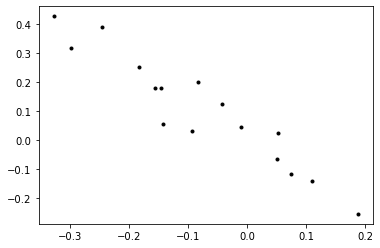

In [313]:
plt.plot(r_before_list,r_after_list,'k.')

[]

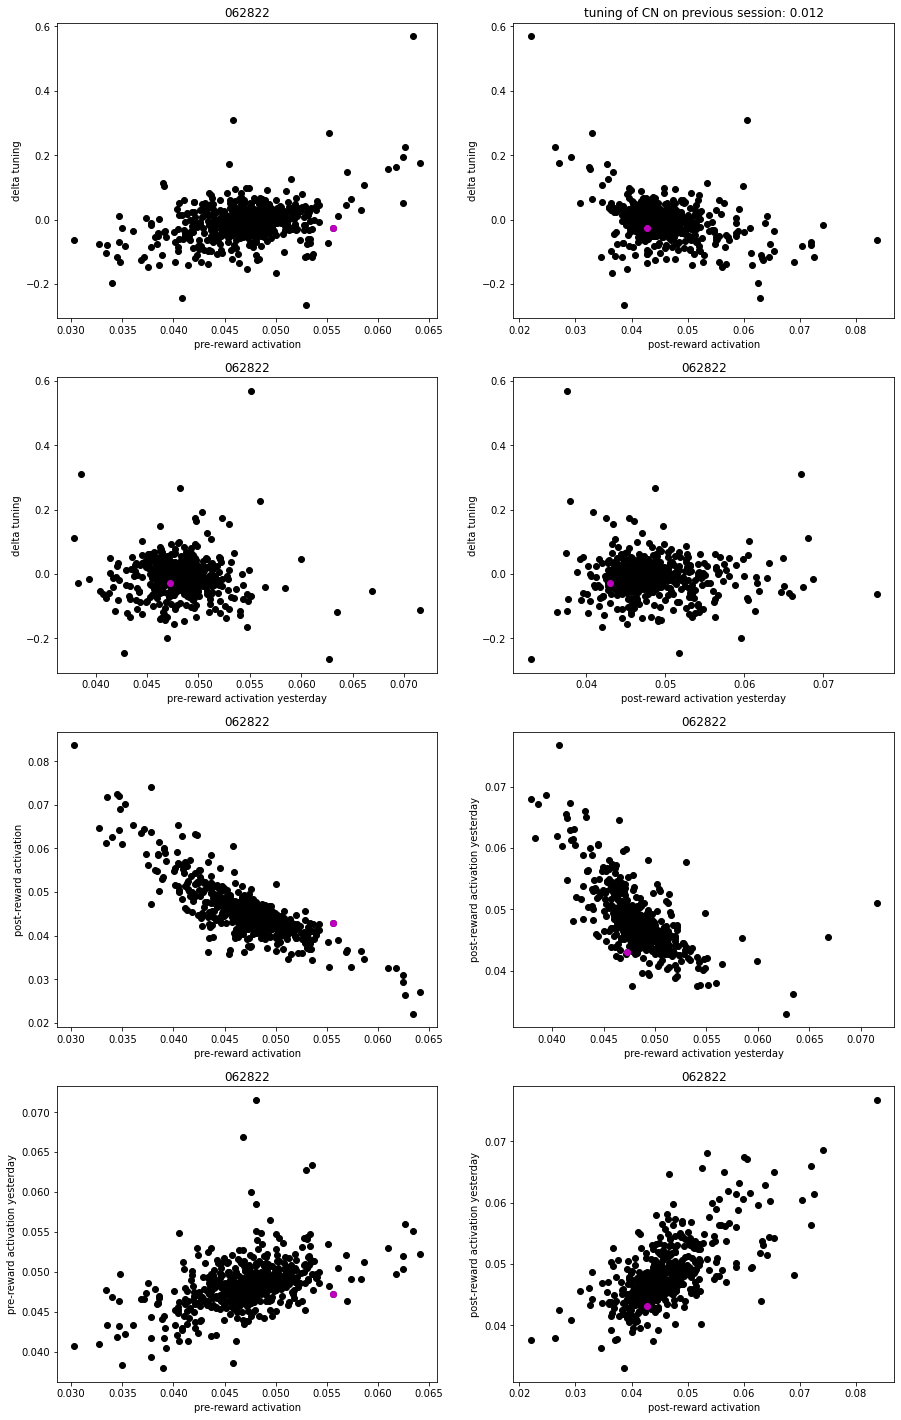

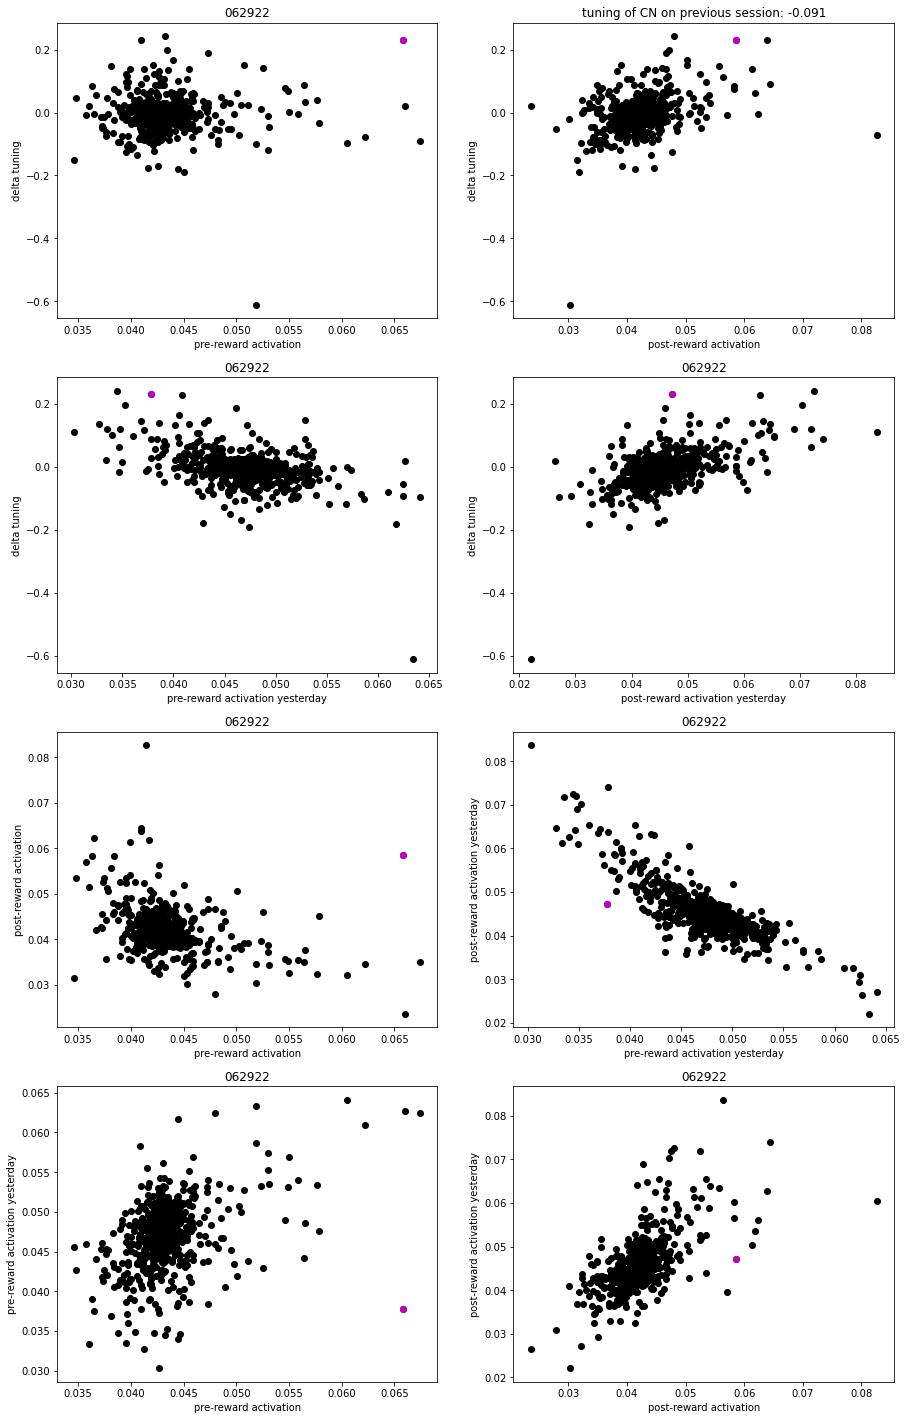

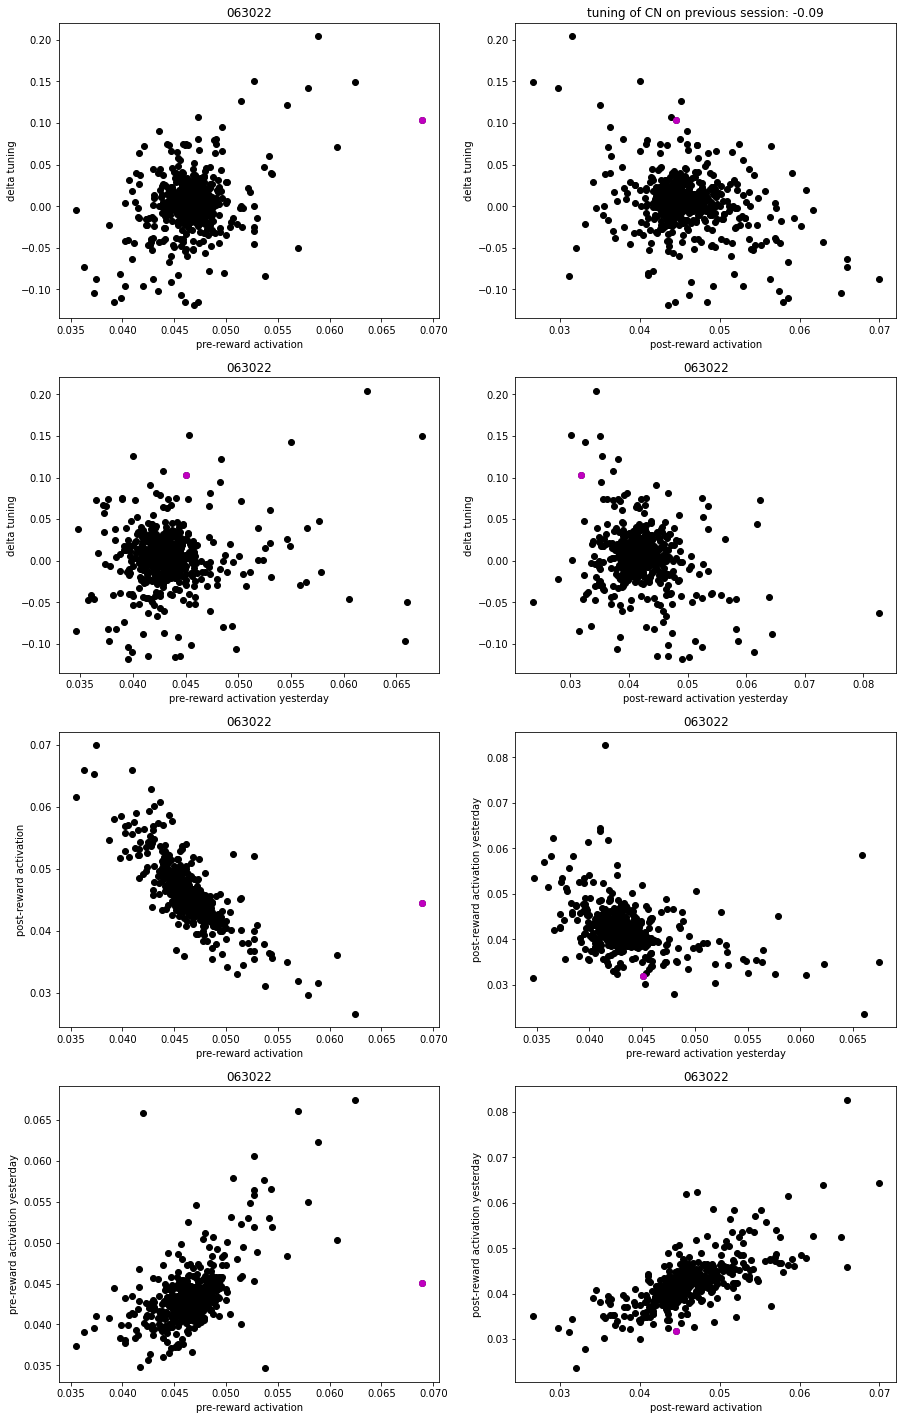

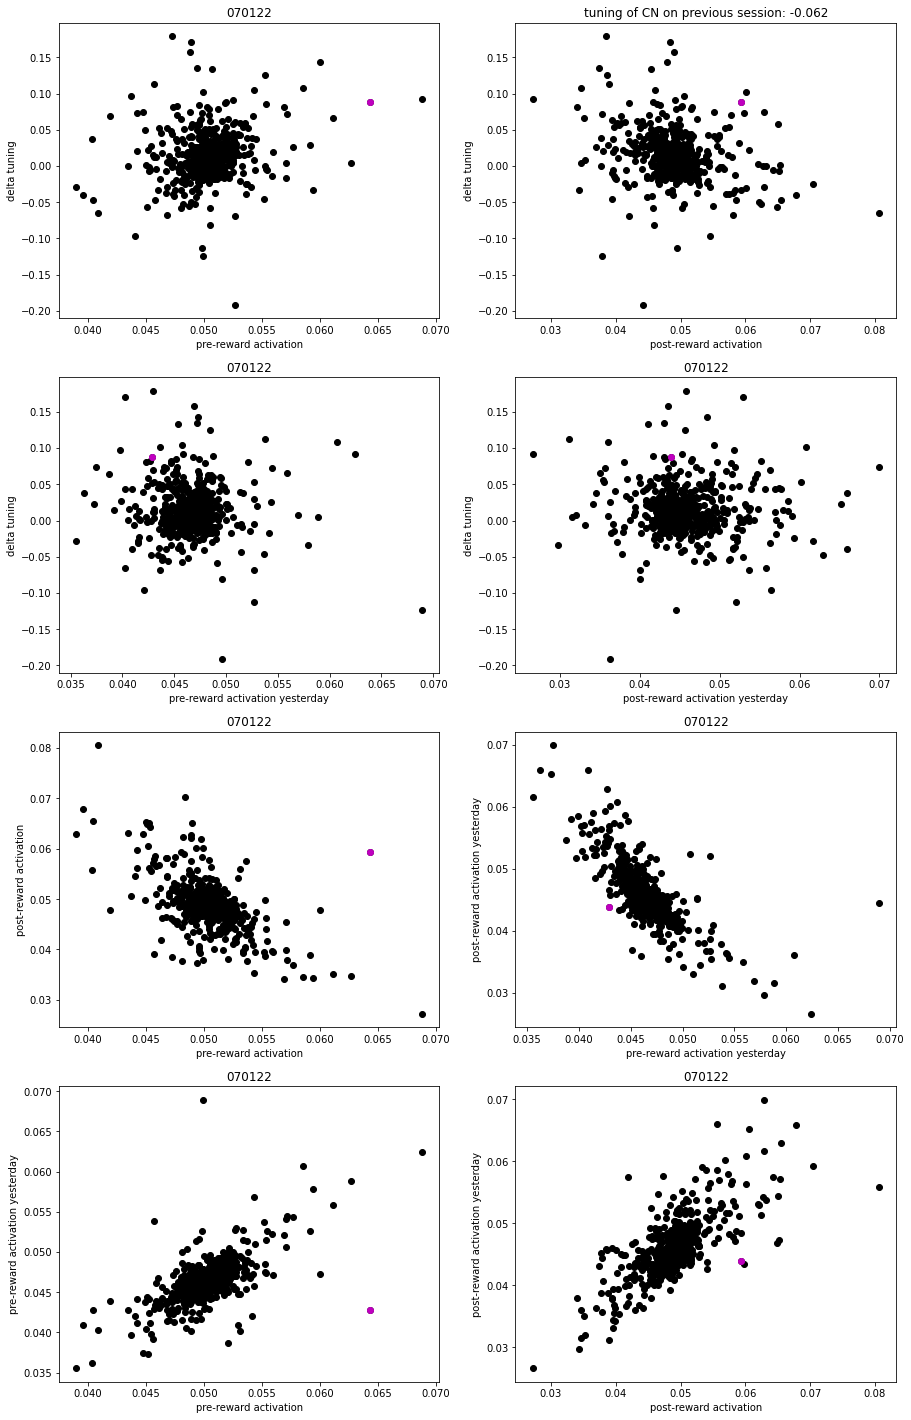

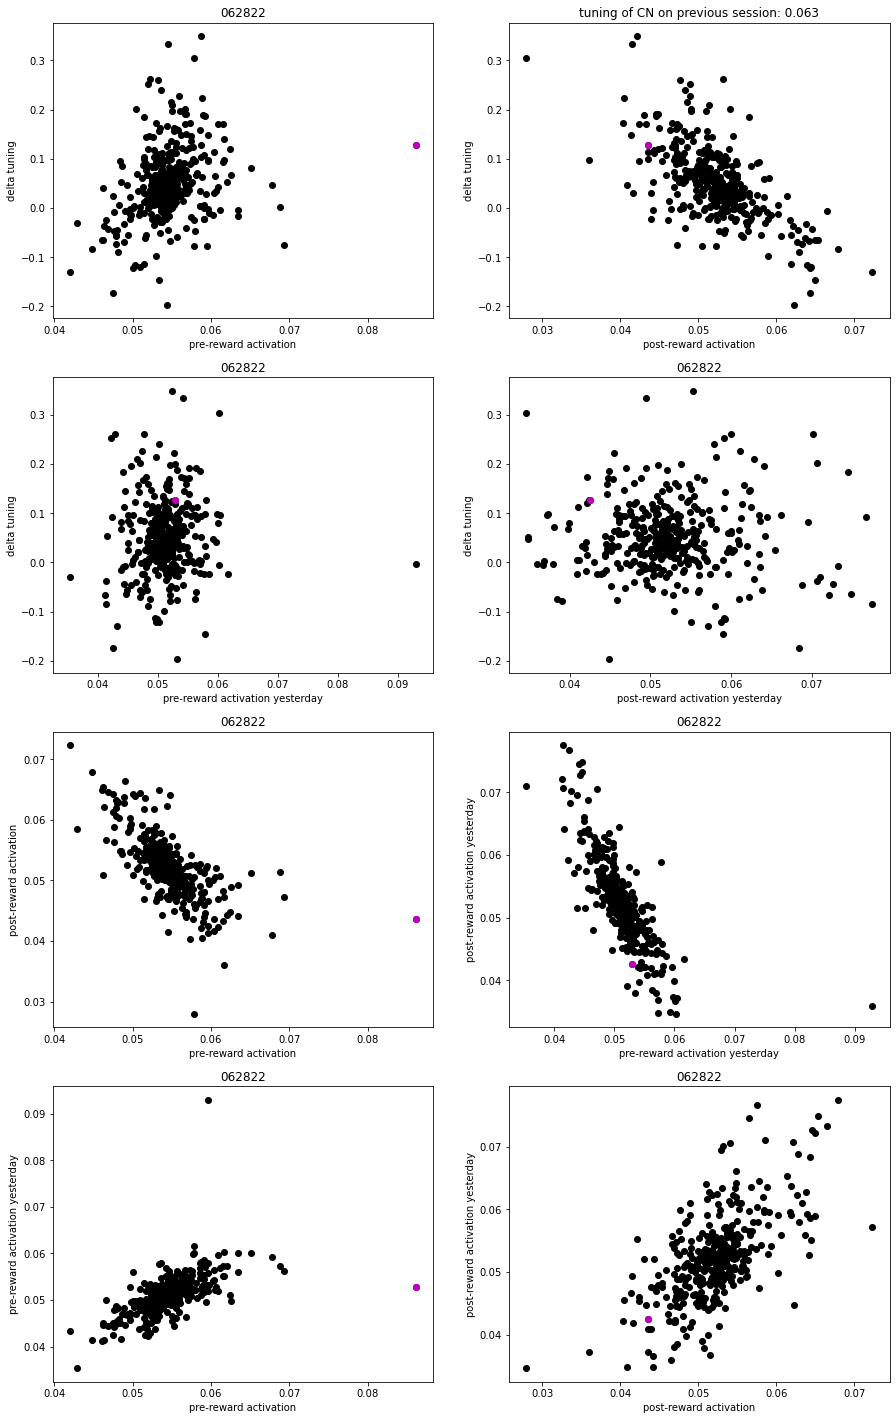

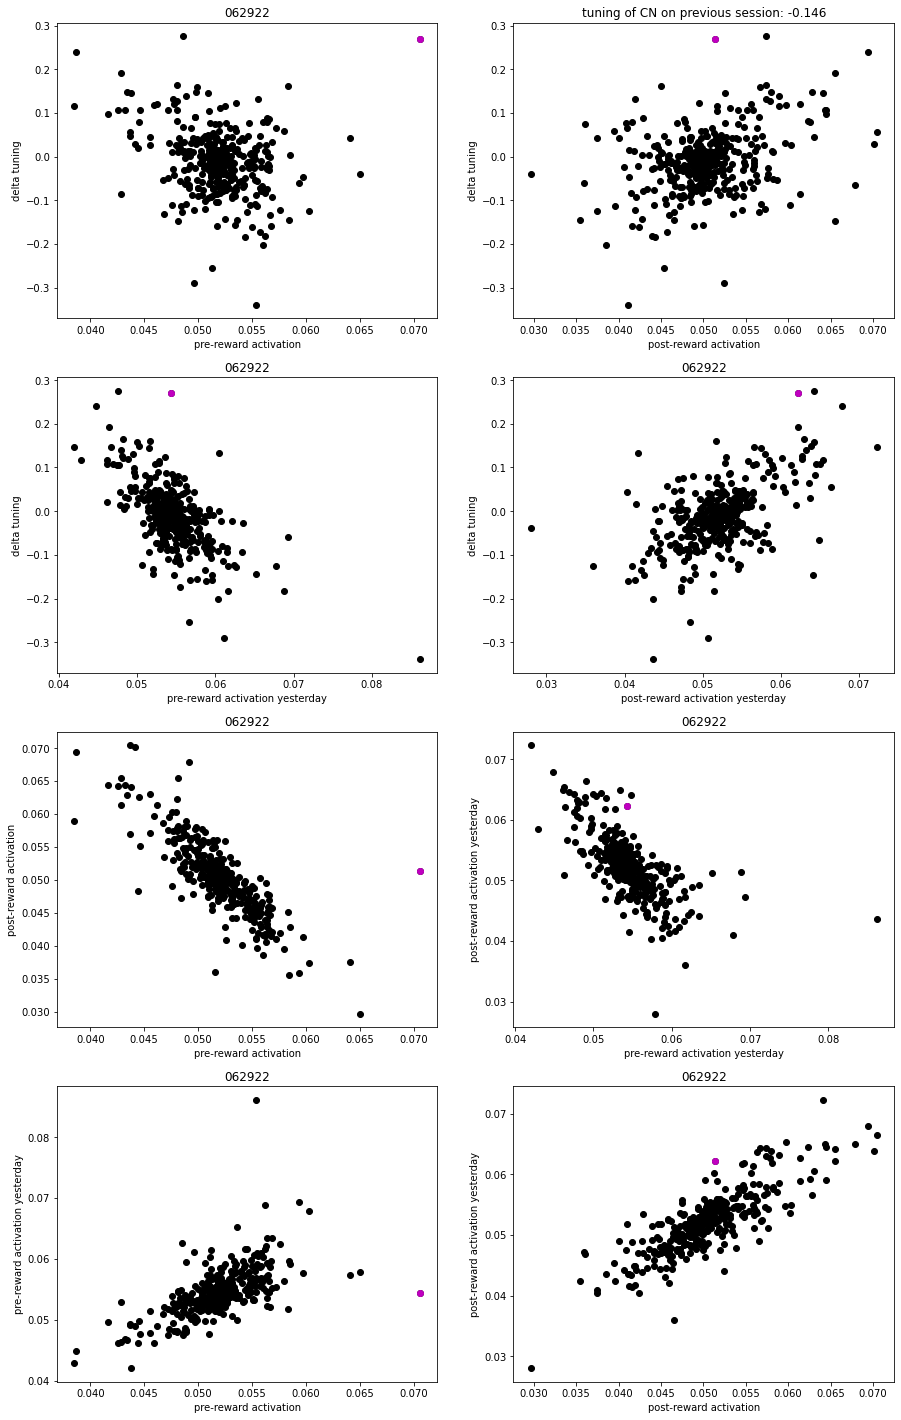

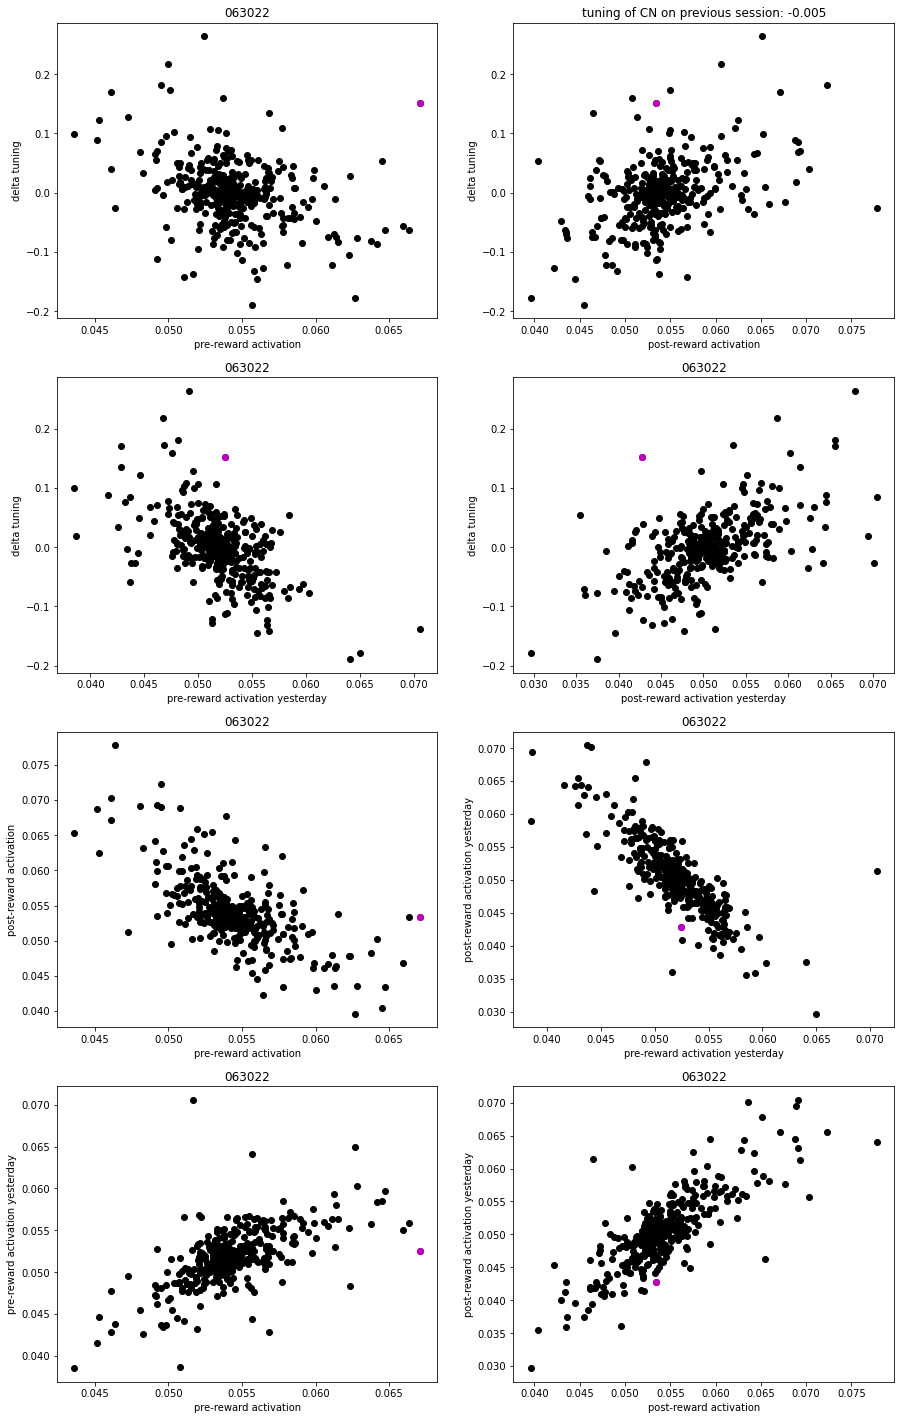

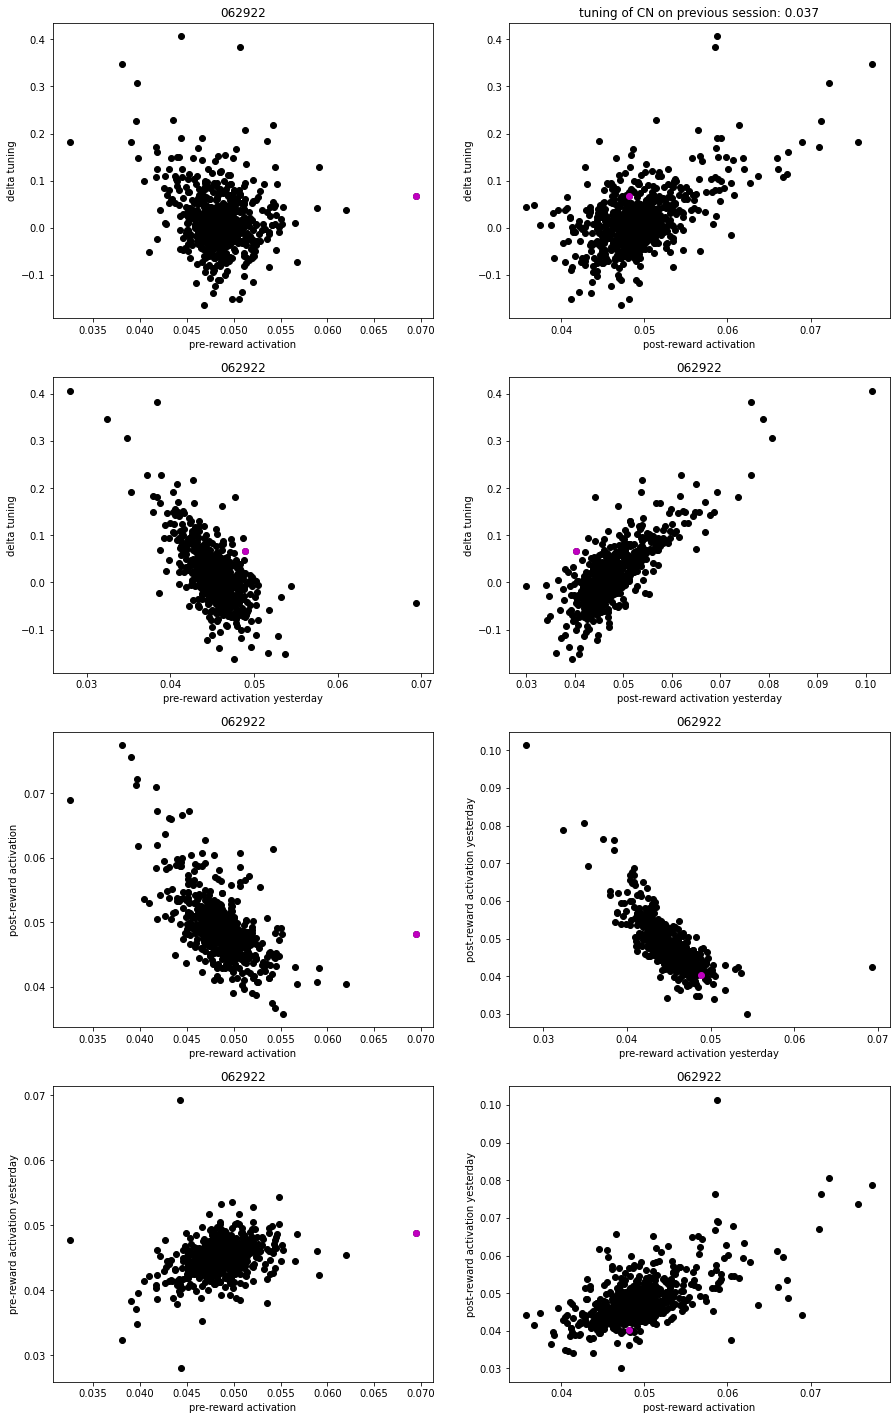

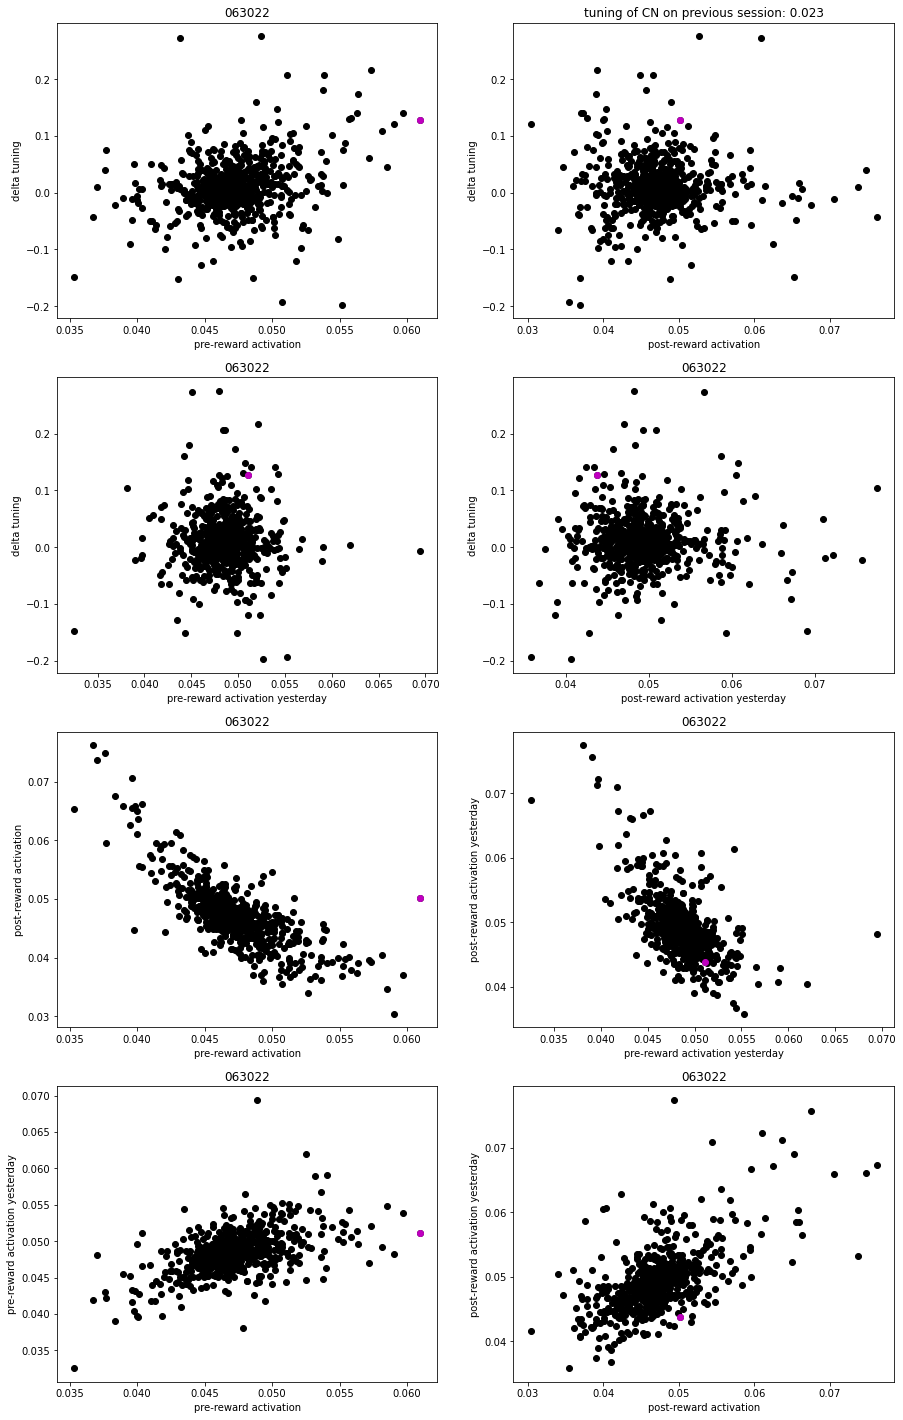

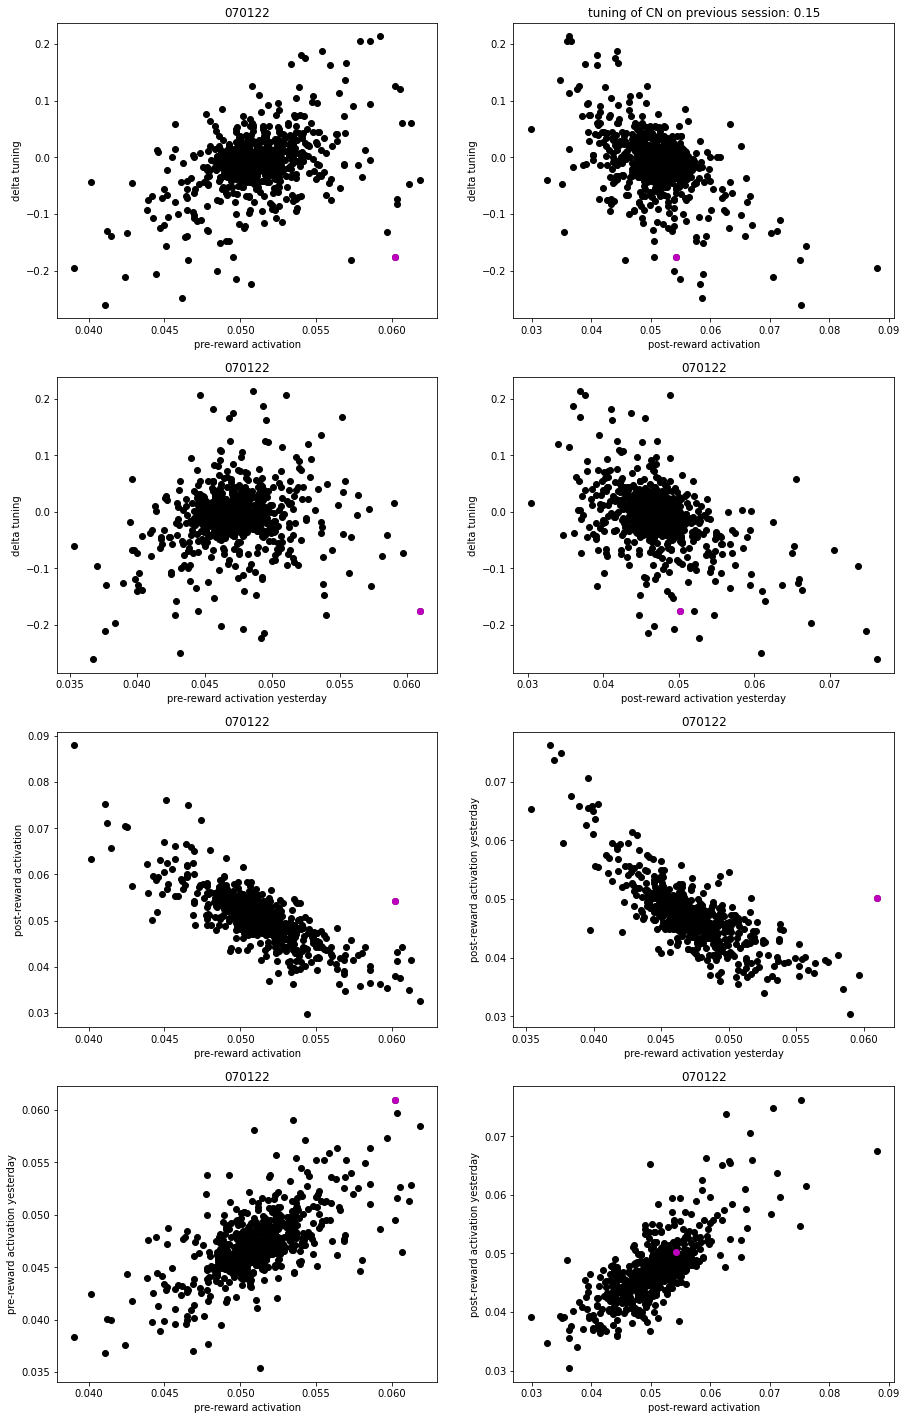

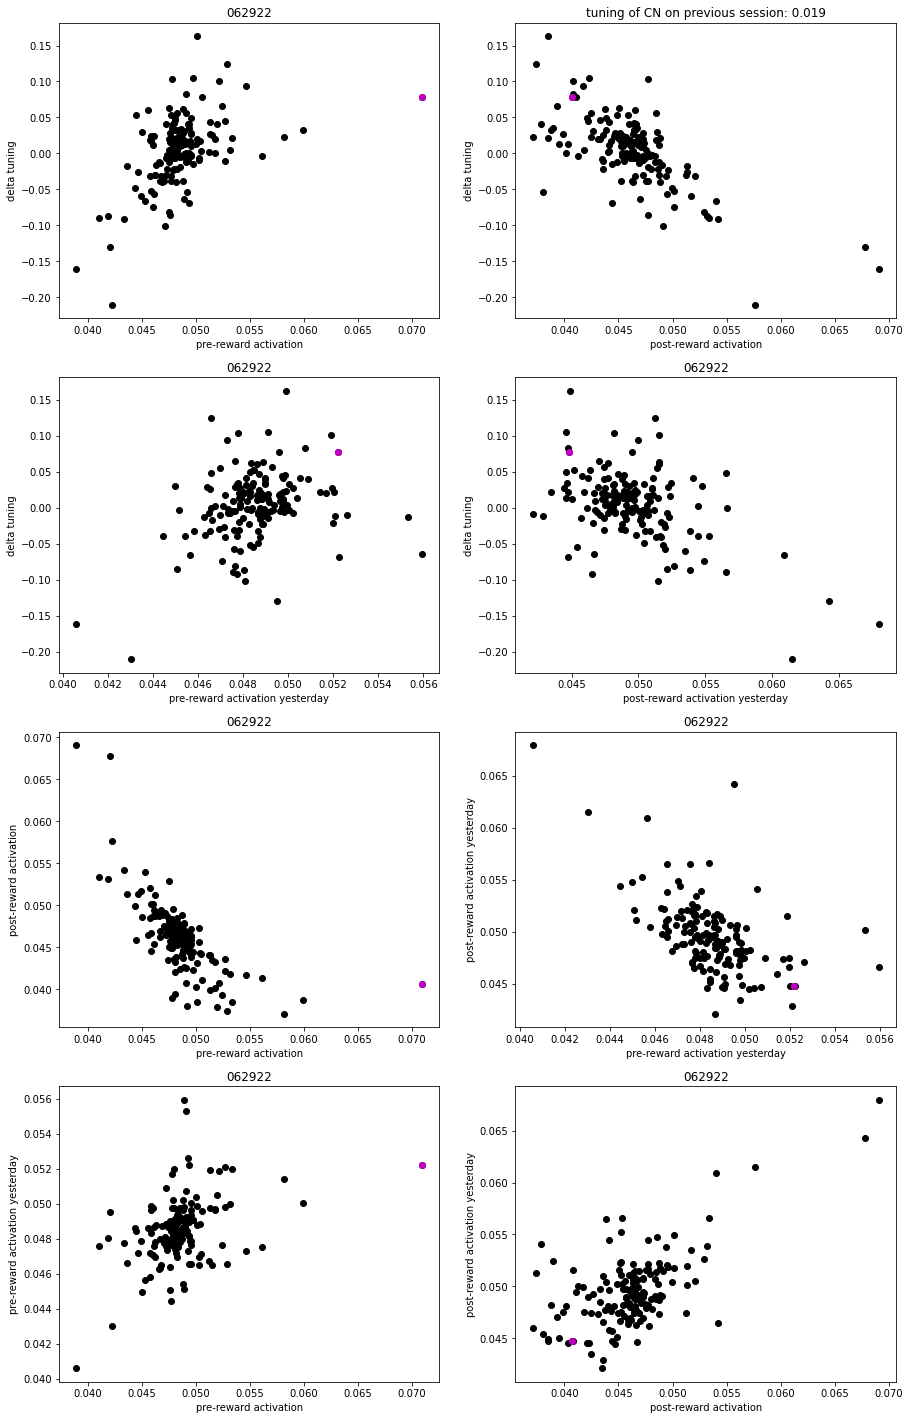

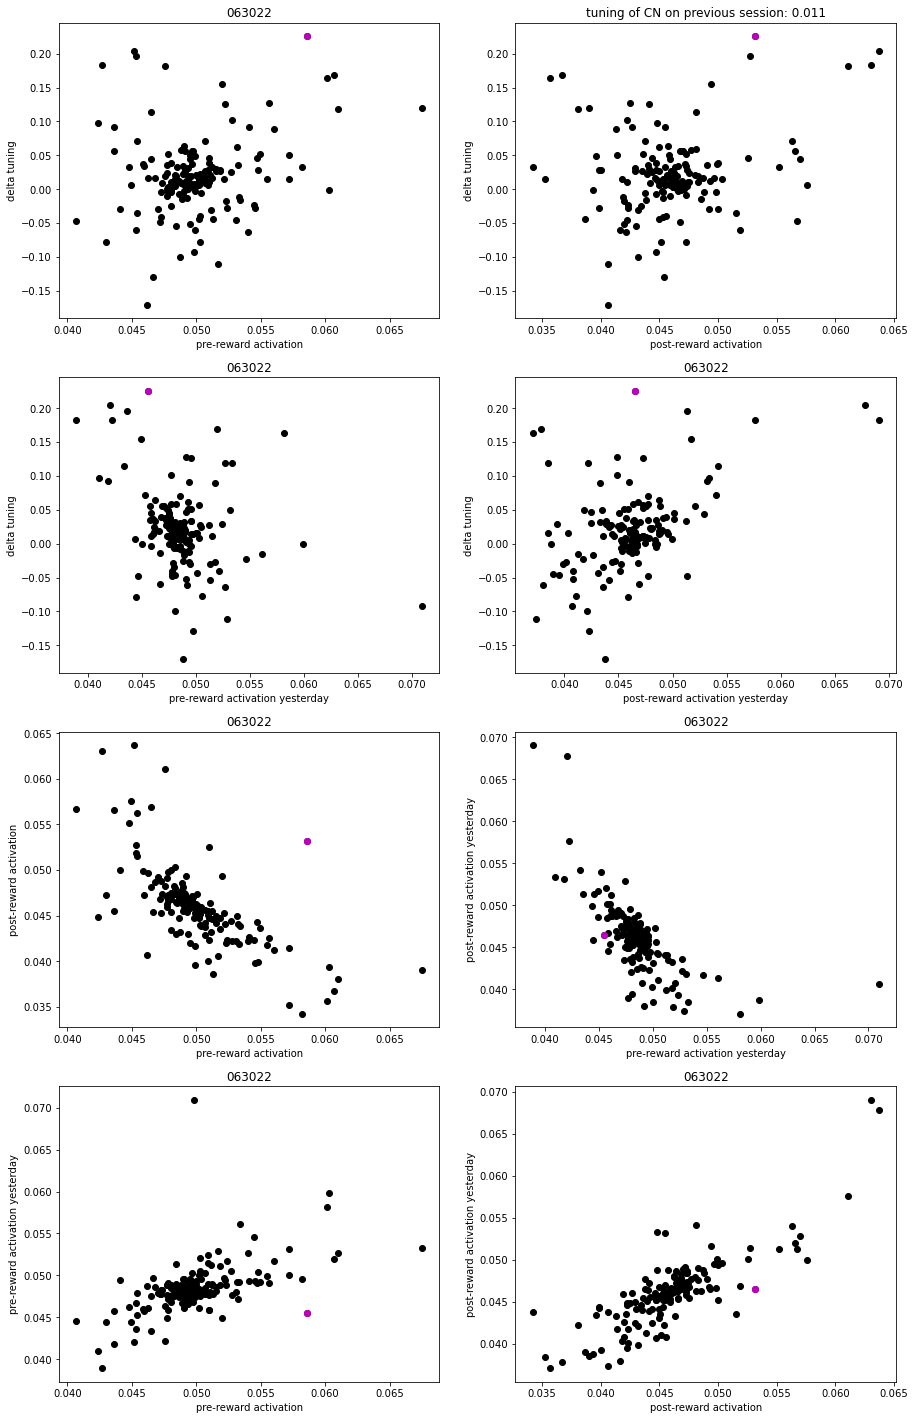

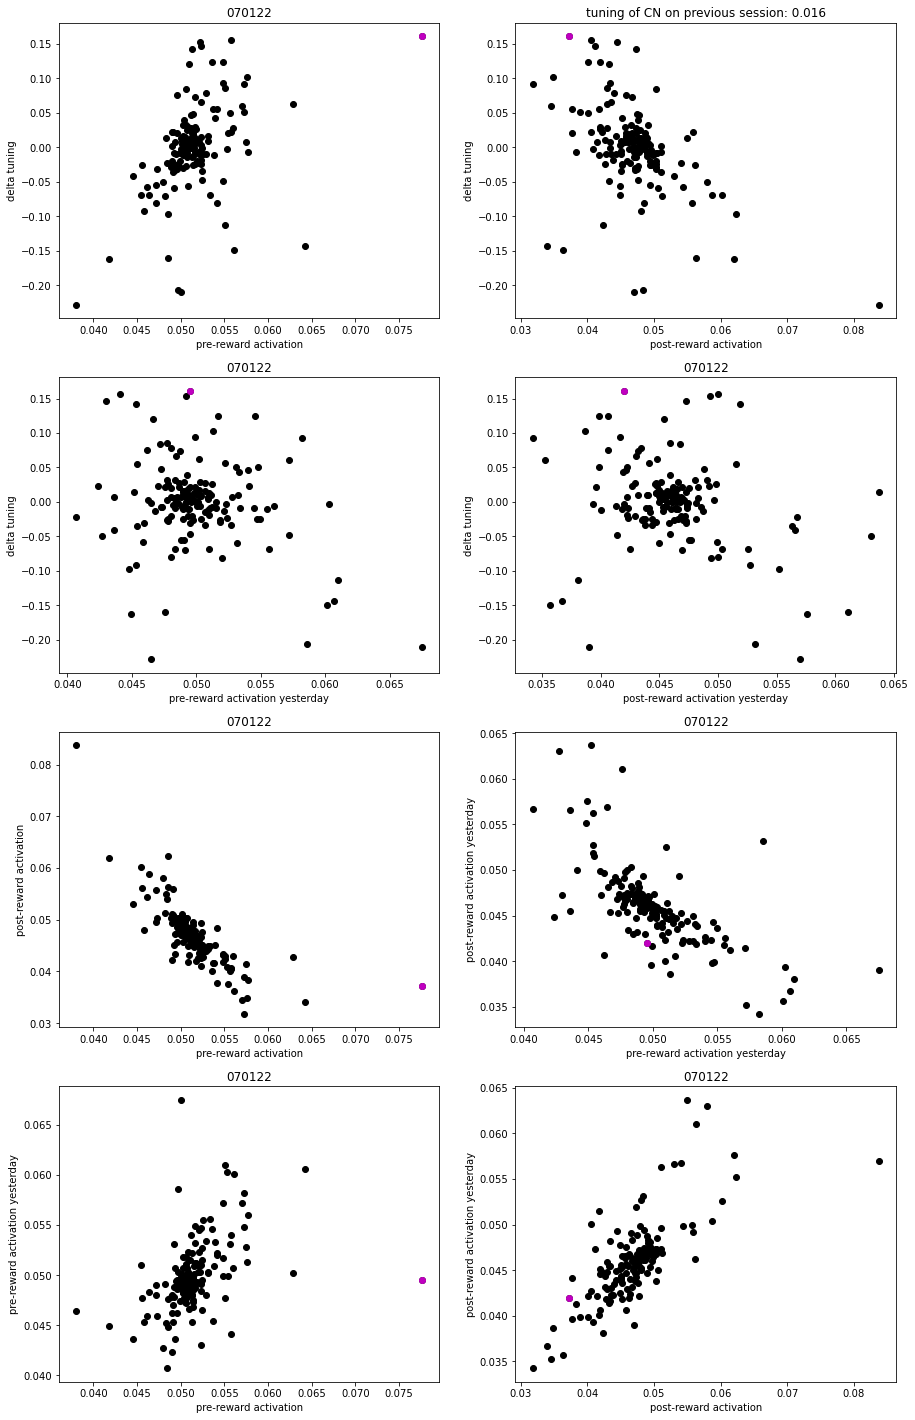

In [354]:
for session_i,session in enumerate(multi_session_dict['session']):
    if len(multi_session_dict['previous_amplitude'][session_i]) == 0:
        continue
    cn = multi_session_dict['cn'][session_i]
    fig = plt.figure(figsize = [15,25])
    ax1=fig.add_subplot(4,2,1)
    x = multi_session_dict['pre_RSI'][session_i]
    y = multi_session_dict['delta_amplitude'][session_i]
    ax1.plot(x,y,'ko')
    ax1.plot(x[cn],y[cn],'mo')
    
    ax1.set_title(session)
    ax1.set_xlabel('pre-reward activation')
    ax1.set_ylabel('delta tuning')
    
    ax2=fig.add_subplot(4,2,2)
    x = multi_session_dict['post_RSI'][session_i]
    y = multi_session_dict['delta_amplitude'][session_i]
    ax2.plot(x,y,'ko')
    ax2.plot(x[cn],y[cn],'mo')
    ax2.set_title('tuning of CN on previous session: {}'.format(np.round(multi_session_dict['previous_amplitude'][session_i][multi_session_dict['cn'][session_i]],3)))
    ax2.set_xlabel('post-reward activation')
    ax2.set_ylabel('delta tuning')
    
    ax3=fig.add_subplot(4,2,3)
    x = multi_session_dict['pre_RSI_yesterday'][session_i]
    y = multi_session_dict['delta_amplitude'][session_i]
    ax3.plot(x,y,'ko')
    ax3.plot(x[cn],y[cn],'mo')
    ax3.set_title(session)
    ax3.set_xlabel('pre-reward activation yesterday')
    ax3.set_ylabel('delta tuning')
    
    ax4=fig.add_subplot(4,2,4)
    x = multi_session_dict['post_RSI_yesterday'][session_i]
    y = multi_session_dict['delta_amplitude'][session_i]
    ax4.plot(x,y,'ko')
    ax4.plot(x[cn],y[cn],'mo')
    ax4.set_title(session)
    ax4.set_xlabel('post-reward activation yesterday')
    ax4.set_ylabel('delta tuning')
    
    
    ax5=fig.add_subplot(4,2,5)
    x = multi_session_dict['pre_RSI'][session_i]
    y = multi_session_dict['post_RSI'][session_i]
    ax5.plot(x,y,'ko')
    ax5.plot(x[cn],y[cn],'mo')
    ax5.set_title(session)
    ax5.set_xlabel('pre-reward activation')
    ax5.set_ylabel('post-reward activation')
    
    ax6=fig.add_subplot(4,2,6)
    x = multi_session_dict['pre_RSI_yesterday'][session_i]
    y = multi_session_dict['post_RSI_yesterday'][session_i]
    ax6.plot(x,y,'ko')
    ax6.plot(x[cn],y[cn],'mo')
    ax6.set_title(session)
    ax6.set_xlabel('pre-reward activation yesterday')
    ax6.set_ylabel('post-reward activation yesterday')
    
    
    
    ax5=fig.add_subplot(4,2,7)
    x = multi_session_dict['pre_RSI'][session_i]
    y = multi_session_dict['pre_RSI_yesterday'][session_i]
    ax5.plot(x,y,'ko')
    ax5.plot(x[cn],y[cn],'mo')
    ax5.set_title(session)
    ax5.set_xlabel('pre-reward activation')
    ax5.set_ylabel('pre-reward activation yesterday')
    
    
    ax6=fig.add_subplot(4,2,8)
    x = multi_session_dict['post_RSI'][session_i]
    y = multi_session_dict['post_RSI_yesterday'][session_i]
    ax6.plot(x,y,'ko')
    ax6.plot(x[cn],y[cn],'mo')
    ax6.set_title(session)
    ax6.set_xlabel('post-reward activation')
    ax6.set_ylabel('post-reward activation yesterday')

In [353]:
# bootstrapping of amplitudes 
#
import BCI_analysis
import scipy
import umap
from sklearn.utils import resample
plot_amplitudes = False
multiple_correlations_per_pair = False
if multiple_correlations_per_pair:
    window_size_pearson = 1200
    pearson_corr_num = 100

max_p = .01#only for plotting significantly increasing cells
n_bootstrap = 1000
step_back = 40 #baseline before trial start (in frames)
step_forward = 200 #integration time after trial start (frames)
exclude_reward = False #
use_reward = False # use changes after reward instead of trial start
trials_for_RSI = 100# how many trials for calculating RSI
#step_forward = 100 # FOR REWAAARD!!
exclude_reward_from_correlations = False
baseline_trial_num = 10
trace_time = np.arange(-step_back,step_forward)/20
# check if CNs are really increasing it's activity - who are the other cells that increase their activity
multi_session_dict['F_trialwise'] = [] #time x neuron x trial
multi_session_dict['F_rewardwise'] = [] #time x neuron x trial
multi_session_dict['amplitude'] = []
multi_session_dict['previous_amplitude'] = []
multi_session_dict['delta_amplitude'] = []
multi_session_dict['p_increase'] = []
multi_session_dict['p_decrease'] = []
multi_session_dict['baseline_amplitude'] = []
multi_session_dict['pre_RSI'] = []
multi_session_dict['post_RSI'] = []
multi_session_dict['pre_RSI_yesterday'] = []
multi_session_dict['post_RSI_yesterday'] = []
if 'pairwise_correlations_matrix' in multi_session_dict.keys():
    cc_already_done = True
else:
    cc_already_done = False
    multi_session_dict['pairwise_correlations_matrix'] = []
    if multiple_correlations_per_pair:
        multi_session_dict['pairwise_correlations_trace_matrix'] = []
    multi_session_dict['pairwise_correlations_matrix_p'] = []
    multi_session_dict['pearson_cc_with_cn'] = []
    multi_session_dict['pearson_cc_with_cn_yesterday'] = []
#cc_already_done = False
    
for session_i,session in enumerate(multi_session_dict['session']):
    print([multi_session_dict['mouse'][session_i],session])
    # trial_start_trace = np.zeros(multi_session_dict['F'][session_i].shape[1])
    # trial_start_trace[np.concatenate([[0],multi_session_dict['trial_end_frames'][session_i][:-1]])] = 1
    trial_start_trace = multi_session_dict['trial_start_original'][session_i]
    
    F_rewardwise = BCI_analysis.io_suite2p.sessionwise_to_trialwise_simple(multi_session_dict['F_original'][session_i],
                                                                            multi_session_dict['reward_original'][session_i],
                                                                            max_frames=None,
                                                                            frames_after=5, 
                                                                            frames_before=5,
                                                                            include_next_trial=True)
    if exclude_reward:
        F_trialwise = BCI_analysis.io_suite2p.sessionwise_to_trialwise_simple_exclude_reward(multi_session_dict['F_original'][session_i],
                                                                                                trial_start_trace,
                                                                                                multi_session_dict['reward_original'][session_i],
                                                                                                max_frames=None,
                                                                                                frames_after=step_forward, 
                                                                                                frames_before=step_back,
                                                                                                invert = False)
    elif use_reward:
        F_trialwise = BCI_analysis.io_suite2p.sessionwise_to_trialwise_simple(multi_session_dict['F_original'][session_i],
                                                                            multi_session_dict['reward_original'][session_i],
                                                                            max_frames=None,
                                                                            frames_after=step_forward, 
                                                                            frames_before=step_back,
                                                                            include_next_trial=True)
        
    else:
        F_trialwise = BCI_analysis.io_suite2p.sessionwise_to_trialwise_simple(multi_session_dict['F_original'][session_i],
                                                                            trial_start_trace,
                                                                            max_frames=None,
                                                                            frames_after=step_forward, 
                                                                            frames_before=step_back,
                                                                            include_next_trial=True)
    
    multi_session_dict['F_trialwise'].append(F_trialwise)
    multi_session_dict['F_rewardwise'].append(F_rewardwise)
   # adads
    if not cc_already_done:
        F_to_use_for_correlations = multi_session_dict['F'][session_i].copy()
        if exclude_reward_from_correlations:
            corr_baseline_len = 40
            F_temp_list = []
            start_frames = np.where(multi_session_dict['trial_start_original'][session_i])[0]
            end_frames = np.concatenate([np.where(multi_session_dict['trial_start_original'][session_i])[0][1:],[len(multi_session_dict['trial_start_original'][session_i])]])
            reward_frames = np.where(multi_session_dict['reward_original'][session_i])[0]
            for start_frame,end_frame in zip(start_frames,end_frames):
                if any((reward_frames>start_frame)& (reward_frames<end_frame)):
                    end_frame = reward_frames[(reward_frames>start_frame)& (reward_frames<end_frame)][0]
                if corr_baseline_len>0 and start_frame>corr_baseline_len:
                    F_temp_list.append(F_to_use_for_correlations[:,start_frame:end_frame]-np.nanmean(F_to_use_for_correlations[:,start_frame-corr_baseline_len:start_frame],1)[:,np.newaxis])
                else:
                    F_temp_list.append(F_to_use_for_correlations[:,start_frame:end_frame])
            F_to_use_for_correlations= np.concatenate(F_temp_list,1)
        pearson_correlation_matrix_all_cells = np.ones([F_to_use_for_correlations.shape[0]]*2)*np.nan
        pearson_correlation_matrix_p_all_cells = np.ones([F_to_use_for_correlations.shape[0]]*2)*np.nan
        pearson_correlation_matrix_population_all_cells = np.asarray(np.ones([F_to_use_for_correlations.shape[0]]*2)*np.nan,dtype = object)
        frame_num =F_to_use_for_correlations.shape[1]
        for neuron_id_to_compare in np.arange(F_to_use_for_correlations.shape[0]):  #multi_session_dict['cn'][session_i]:
            for neuron_idx in np.arange(neuron_id_to_compare,F_to_use_for_correlations.shape[0]):
                if neuron_idx == neuron_id_to_compare:#multi_session_dict['cn'][session_i]:
                    pearsons_R = np.nan
                    pearsons_p = np.nan
                    corr_list = []
                else:
                    pearsons_R, pearsons_p = scipy.stats.pearsonr(F_to_use_for_correlations[neuron_idx,:],
                                                                   F_to_use_for_correlations[neuron_id_to_compare,:])
                    if multiple_correlations_per_pair:
                        corr_list = []
                        window_center_list = []
                        window_step_pearson = int((frame_num-window_size_pearson)/pearson_corr_num)
                        for wstart in np.arange(0,frame_num-window_size_pearson,window_step_pearson):
                            wend = wstart + window_size_pearson
                            window_center_list.append(wstart+window_size_pearson/2)
                            pearsons_R, pearsons_p = scipy.stats.pearsonr(F_to_use_for_correlations[neuron_idx,wstart:wend],  F_to_use_for_correlations[neuron_id_to_compare,wstart:wend])
                            corr_list.append(pearsons_R)
                # if len(corr_list)>0:
                #     asdasd
                pearson_correlation_matrix_all_cells[neuron_id_to_compare,neuron_idx] = pearsons_R
                pearson_correlation_matrix_p_all_cells[neuron_id_to_compare,neuron_idx] = pearsons_p
                
                pearson_correlation_matrix_population_all_cells[neuron_id_to_compare,neuron_idx] = np.asarray(corr_list)
        #asdasd
        multi_session_dict['pairwise_correlations_matrix'].append(pearson_correlation_matrix_all_cells)
        if multiple_correlations_per_pair:
            multi_session_dict['pairwise_correlations_trace_matrix'].append(pearson_correlation_matrix_population_all_cells)
        multi_session_dict['pairwise_correlations_matrix_p'].append(pearson_correlation_matrix_p_all_cells)
    
    
    
    if session_i >0:
        if multi_session_dict['F'][session_i].shape[0] == multi_session_dict['F'][session_i-1].shape[0]: #there is a previous session

            
            
            F_for_rewards = multi_session_dict['F_original'][session_i]
            F_for_rewards = (F_for_rewards- np.nanmin(F_for_rewards,1)[:,np.newaxis])# made non-negative
            F_rewardwise_after = BCI_analysis.io_suite2p.sessionwise_to_trialwise_simple(F_for_rewards,
                                                                                        multi_session_dict['reward_original'][session_i],
                                                                                        max_frames=None,
                                                                                        frames_after=60 ,
                                                                                        frames_before=-40,
                                                                                        include_next_trial=False)
  
            F_rewardwise_before = BCI_analysis.io_suite2p.sessionwise_to_trialwise_simple(F_for_rewards,
                                                                                        multi_session_dict['reward_original'][session_i],
                                                                                        max_frames=None,
                                                                                        frames_after=-20 ,
                                                                                        frames_before=40,
                                                                                        include_next_trial=False)


            trial_start_trace = multi_session_dict['trial_start_original'][session_i]
            F_trialwise_ctrl = BCI_analysis.io_suite2p.sessionwise_to_trialwise_simple(F_for_rewards,
                                                                                        multi_session_dict['reward_original'][session_i],#trial_start_trace,
                                                                                        max_frames=None,
                                                                                        frames_after=300, 
                                                                                        frames_before=200,
                                                                                        include_next_trial=False)
            RSI_before_trial = np.nansum(F_rewardwise_before,0)[:,:trials_for_RSI]/np.nansum(F_trialwise_ctrl,0)[:,:trials_for_RSI]
            RSI_before = np.nanmean(RSI_before_trial,1)
            

            RSI_after_trial = np.nansum(F_rewardwise_after,0)[:,:trials_for_RSI]/np.nansum(F_trialwise_ctrl,0)[:,:trials_for_RSI]
            RSI_after = np.nanmean(RSI_after_trial,1)
            
            
            
            multi_session_dict['pre_RSI'].append(RSI_before)
            multi_session_dict['post_RSI'].append(RSI_after)
            
            
            F_for_rewards = multi_session_dict['F_original'][session_i-1]
            F_for_rewards = (F_for_rewards- np.nanmin(F_for_rewards,1)[:,np.newaxis])# made non-negative
            F_rewardwise_after = BCI_analysis.io_suite2p.sessionwise_to_trialwise_simple(F_for_rewards,
                                                                                        multi_session_dict['reward_original'][session_i-1],
                                                                                        max_frames=None,
                                                                                        frames_after=60 ,
                                                                                        frames_before=-40,
                                                                                        include_next_trial=False)
  
            F_rewardwise_before = BCI_analysis.io_suite2p.sessionwise_to_trialwise_simple(F_for_rewards,
                                                                                        multi_session_dict['reward_original'][session_i-1],
                                                                                        max_frames=None,
                                                                                        frames_after=-20 ,
                                                                                        frames_before=40,
                                                                                        include_next_trial=False)


            trial_start_trace = multi_session_dict['trial_start_original'][session_i-1]
            F_trialwise_ctrl = BCI_analysis.io_suite2p.sessionwise_to_trialwise_simple(F_for_rewards,
                                                                                        multi_session_dict['reward_original'][session_i-1],#trial_start_trace,
                                                                                        max_frames=None,
                                                                                        frames_after=300, 
                                                                                        frames_before=200,
                                                                                        include_next_trial=False)
            RSI_before_trial = np.nansum(F_rewardwise_before,0)[:,:trials_for_RSI]/np.nansum(F_trialwise_ctrl,0)[:,:trials_for_RSI]
            RSI_before = np.nanmean(RSI_before_trial,1)
            

            RSI_after_trial = np.nansum(F_rewardwise_after,0)[:,:trials_for_RSI]/np.nansum(F_trialwise_ctrl,0)[:,:trials_for_RSI]
            RSI_after = np.nanmean(RSI_after_trial,1)
            
            
            
            multi_session_dict['pre_RSI_yesterday'].append(RSI_before)
            multi_session_dict['post_RSI_yesterday'].append(RSI_after)
            
            
            
            
            
            
            
            
            
            
            
            pearson_correlation_matrix_all_cells = multi_session_dict['pairwise_correlations_matrix'][session_i]
            pearson_correlation_matrix_all_cells_yesterday = multi_session_dict['pairwise_correlations_matrix'][session_i-1]
            cn = multi_session_dict['cn'][session_i]
            pearson_list = np.nanmax([pearson_correlation_matrix_all_cells[cn,:],pearson_correlation_matrix_all_cells[:,cn]],0).flatten()
            multi_session_dict['pearson_cc_with_cn'].append(pearson_list)
            pearson_list_yesterday = np.nanmax([pearson_correlation_matrix_all_cells_yesterday[cn,:],pearson_correlation_matrix_all_cells_yesterday[:,cn]],0).flatten()
            multi_session_dict['pearson_cc_with_cn_yesterday'].append(pearson_list_yesterday)
            
            now_amplitudes = (np.nanmean(multi_session_dict['F_trialwise'][session_i][step_back:,:,1:],0) - np.nanmean(multi_session_dict['F_trialwise'][session_i][:step_back,:,1:],0))
            prev_amplitudes = (np.nanmean(multi_session_dict['F_trialwise'][session_i-1][step_back:,:,1:],0) - np.nanmean(multi_session_dict['F_trialwise'][session_i-1][:step_back,:,1:],0))
            real_deltas = np.nanmean(now_amplitudes,1)-np.nanmean(prev_amplitudes,1)
            cn = multi_session_dict['cn'][session_i]

            
            prev_mean_amplitude_bootstrap_list = []
            now_mean_amplitude_bootstrap_list = []

            for bootstrap_i in range(n_bootstrap):
                now_indices = resample(np.arange(now_amplitudes.shape[1]))
                now_mean_amplitude_bootstrap_list.append(np.mean(now_amplitudes[:,now_indices],1))
                prev_indices = resample(np.arange(prev_amplitudes.shape[1]))
                prev_mean_amplitude_bootstrap_list.append(np.mean(prev_amplitudes[:,prev_indices],1))
            now_mean_amplitude_bootstrap_list = np.asarray(now_mean_amplitude_bootstrap_list)
            prev_mean_amplitude_bootstrap_list = np.asarray(prev_mean_amplitude_bootstrap_list)
            delta_amplitudes_bootstrap = now_mean_amplitude_bootstrap_list-prev_mean_amplitude_bootstrap_list
            delta_sd = np.std(delta_amplitudes_bootstrap,0)


            cell_order = np.argsort(real_deltas)
            significantly_increasing_indices = 1-np.nanmean(delta_amplitudes_bootstrap>0,0)[cell_order]<max_p
            significantly_decreasing_indices = 1-np.nanmean(delta_amplitudes_bootstrap<0,0)[cell_order]<max_p
            
            multi_session_dict['delta_amplitude'].append(real_deltas)
            multi_session_dict['p_increase'].append(1-np.nanmean(delta_amplitudes_bootstrap>0,0))
            multi_session_dict['p_decrease'].append(1-np.nanmean(delta_amplitudes_bootstrap<0,0))
            multi_session_dict['amplitude'].append(np.nanmean(now_amplitudes,1))
            multi_session_dict['previous_amplitude'].append(np.nanmean(prev_amplitudes,1))
            baseline_amplitudes = np.nanmean(now_amplitudes[:,:baseline_trial_num],1)
            multi_session_dict['baseline_amplitude'].append(baseline_amplitudes)
            if plot_amplitudes:
                fig = plt.figure(figsize = [15,30])
                ax = fig.add_subplot(6,2,1)

                ax.plot(np.argmax(cell_order==cn),real_deltas[cn],'mx',markersize = 20,markeredgewidth = 4)
                ax.errorbar(np.arange(len(cell_order)),real_deltas[cell_order],yerr = delta_sd[cell_order],fmt='.',color = 'black',alpha = .5)
                ax.plot(np.arange(len(cell_order))[significantly_increasing_indices],real_deltas[cell_order][significantly_increasing_indices],'ro')
                ax.plot(np.arange(len(cell_order))[significantly_decreasing_indices],real_deltas[cell_order][significantly_decreasing_indices],'bo')
                ax.set_xlabel('cell#')
                ax.set_ylabel('Delta amplitude (dF/F)')
                ax.set_title('{} - {} to {} - neuron {}  p = {}'.format(multi_session_dict['mouse'][session_i],
                                                                        multi_session_dict['session'][session_i-1],
                                                                        multi_session_dict['session'][session_i],
                                                                        multi_session_dict['cn'][session_i],
                                                                        np.round(1-np.nanmean(delta_amplitudes_bootstrap>0,0)[cn],5)))
                significantly_increasing_indices = 1-np.nanmean(delta_amplitudes_bootstrap>0,0)<max_p
                significantly_decreasing_indices = 1-np.nanmean(delta_amplitudes_bootstrap<0,0)<max_p
                #now_ampls = sklearn.utils.resample(now_amplitudes)

                ax = fig.add_subplot(6,2,2)
                ax.plot(np.nanmean(prev_amplitudes,1)[cn],real_deltas[cn],'mx',markersize = 20,markeredgewidth = 4)
                ax.plot(np.nanmean(prev_amplitudes,1),real_deltas,'.',color = 'black')
                ax.errorbar(np.nanmean(prev_amplitudes,1),real_deltas,yerr = delta_sd,fmt='.',color = 'black',alpha = .5)
                ax.plot(np.nanmean(prev_amplitudes,1)[significantly_increasing_indices],real_deltas[significantly_increasing_indices],'ro')
                ax.plot(np.nanmean(prev_amplitudes,1)[significantly_decreasing_indices],real_deltas[significantly_decreasing_indices],'bo')
                ax.set_xlabel('Amplitude in previous session (dF/F)')
                ax.set_ylabel('Delta amplitude (dF/F)')
                ax.set_title('{} - {} to {} - neuron {}  p = {}'.format(multi_session_dict['mouse'][session_i],
                                                                        multi_session_dict['session'][session_i-1],
                                                                        multi_session_dict['session'][session_i],
                                                                        multi_session_dict['cn'][session_i],
                                                                        np.round(1-np.nanmean(delta_amplitudes_bootstrap>0,0)[cn],5)))     
                ax = fig.add_subplot(6,2,4)
                today_deltas = np.nanmean(now_amplitudes,1)-baseline_amplitudes
                #ax.plot(today_deltas,real_deltas,'k.')
                
                ax.plot(today_deltas[cn],real_deltas[cn],'mx',markersize = 20,markeredgewidth = 4)
                ax.plot(today_deltas,real_deltas,'.',color = 'black')
                #ax.errorbar(today_deltas,real_deltas,yerr = delta_sd,fmt='.',color = 'black',alpha = .5)
                ax.plot(today_deltas[significantly_increasing_indices],real_deltas[significantly_increasing_indices],'ro')
                ax.plot(today_deltas[significantly_decreasing_indices],real_deltas[significantly_decreasing_indices],'bo')
                ax.set_xlabel('Delta amplitude relative to first {} trials (dF/F)'.format(baseline_trial_num))
                ax.set_ylabel('Delta amplitude (dF/F)')
                
                
                ax = fig.add_subplot(6,2,3)
                
                
                ax.plot(pearson_list_yesterday[cn],pearson_list[cn],'mx',markersize = 20,markeredgewidth = 4)
                ax.plot(pearson_list_yesterday,pearson_list,'.',color = 'black')
                #ax.errorbar(today_deltas,real_deltas,yerr = delta_sd,fmt='.',color = 'black',alpha = .5)
                ax.plot(pearson_list_yesterday[significantly_increasing_indices],pearson_list[significantly_increasing_indices],'ro')
                ax.plot(pearson_list_yesterday[significantly_decreasing_indices],pearson_list[significantly_decreasing_indices],'bo')
                ax.set_xlabel('Pearson correlation with CN on control day')
                ax.set_ylabel('Pearson correlation with CN on conditioning day')
                limits = [ax.get_xlim(),ax.get_ylim()]
                limits = [np.min(limits),np.max(limits)]
                ax.set_xlim(limits)
                ax.set_ylim(limits)
                
                pearson_correlation_matrix_all_cells = multi_session_dict['pairwise_correlations_matrix'][session_i]
                pearson_correlation_matrix_all_cells_yesterday = multi_session_dict['pairwise_correlations_matrix'][session_i-1]
                pearson_2_list = []
                pearson_2_p_list = []
                for cell_idx in np.arange(pearson_correlation_matrix_all_cells.shape[0]):
                    x = pearson_list = np.nanmax([pearson_correlation_matrix_all_cells[cell_idx,:],pearson_correlation_matrix_all_cells[:,cell_idx]],0).flatten()
                    y = pearson_list = np.nanmax([pearson_correlation_matrix_all_cells_yesterday[cell_idx,:],pearson_correlation_matrix_all_cells_yesterday[:,cell_idx]],0).flatten()
                    needed = (np.isnan(x)==False) & (np.isnan(y)==False)
                    pearsons_R, pearsons_p = scipy.stats.pearsonr(x[needed],y[needed])
                    pearson_2_list.append(pearsons_R)
                    pearson_2_p_list.append(pearsons_p)
                pearson_2_list = np.asarray(pearson_2_list)
                pearson_2_p_list = np.asarray(pearson_2_p_list)
                significant = pearson_2_p_list<.01
                insignificant = pearson_2_p_list>=.01
                ax = fig.add_subplot(6,2,5)
                ax.plot(pearson_2_list[cn],real_deltas[cn],'mx',markersize = 20,markeredgewidth = 4)
                
                ax.plot(pearson_2_list[insignificant],real_deltas[insignificant],'.',color = 'black',alpha = .2)
                ax.plot(pearson_2_list[significant],real_deltas[significant],'.',color = 'black',alpha = 1)
                #ax.errorbar(today_deltas,real_deltas,yerr = delta_sd,fmt='.',color = 'black',alpha = .5)
                ax.plot(pearson_2_list[significantly_increasing_indices&insignificant],real_deltas[significantly_increasing_indices&insignificant],'ro',alpha = .2)
                ax.plot(pearson_2_list[significantly_decreasing_indices&insignificant],real_deltas[significantly_decreasing_indices&insignificant],'bo',alpha = .2)
                ax.plot(pearson_2_list[significantly_increasing_indices&significant],real_deltas[significantly_increasing_indices&significant],'ro',alpha = 1)
                ax.plot(pearson_2_list[significantly_decreasing_indices&significant],real_deltas[significantly_decreasing_indices&significant],'bo',alpha = 1)
                ax.set_ylabel('Delta amplitude (dF/F)')
                ax.set_xlabel('Correlation of pairwise correlation coefficients from day to day')
                
                
                ax = fig.add_subplot(6,2,6)
                
                ax.plot(np.nanmean(prev_amplitudes,1),np.nanmean(now_amplitudes,1),'k.',alpha= .5)#real_deltas,
                ax.plot(np.nanmean(prev_amplitudes,1)[cn],np.nanmean(now_amplitudes,1)[cn],'mx',markersize = 20,markeredgewidth = 4)
                
                ax.plot(np.nanmean(prev_amplitudes,1)[significantly_increasing_indices],np.nanmean(now_amplitudes,1)[significantly_increasing_indices],'ro')
                ax.plot(np.nanmean(prev_amplitudes,1)[significantly_decreasing_indices],np.nanmean(now_amplitudes,1)[significantly_decreasing_indices],'bo')
                limits = np.concatenate([ax.get_xlim(),ax.get_ylim()])
                limits = [np.min(limits),np.max(limits)]
                ax.set_xlim(limits)
                ax.set_ylim(limits)
                ax.set_xlabel('Amplitude on previous session')
                ax.set_ylabel('Amplitude on conditioning session')
                
                amplitude_color_edges = np.percentile(np.concatenate([np.nanmean(now_amplitudes,1),np.nanmean(prev_amplitudes,1)]),[5,95])
                
                
                ax = fig.add_subplot(6,2,7)
                matrix_now = np.nanmean([pearson_correlation_matrix_all_cells_yesterday,pearson_correlation_matrix_all_cells_yesterday.T],0)
                matrix_now[np.isnan(matrix_now)] = 1
                reducer = umap.UMAP()

                #sil = []
                #kmax = 20
                reducer.n_neighbors=5
                reducer.min_dist = 0.05 
                umap_embedding = reducer.fit_transform(matrix_now)

                coordinates = umap_embedding

                # ax.plot(coordinates[:,0],coordinates[:,1],'k.',alpha = .5)
                ax.plot(coordinates[cn,0],coordinates[cn,1],'mx',markersize = 20,markeredgewidth = 4)
                # #ax.errorbar(today_deltas,real_deltas,yerr = delta_sd,fmt='.',color = 'black',alpha = .5)
                # ax.plot(coordinates[significantly_increasing_indices,0],coordinates[significantly_increasing_indices,1],'ro')
                # ax.plot(coordinates[significantly_decreasing_indices,0],coordinates[significantly_decreasing_indices,1],'bo')
                ax.scatter(coordinates[:,0],
                           coordinates[:,1],
                           c= np.nanmean(prev_amplitudes,1),
                           alpha = .5,
                           vmin = amplitude_color_edges[0],
                          vmax =  amplitude_color_edges[1])
                ax.set_xlabel('UMAP1')
                ax.set_ylabel('UMAP2')
                ax.set_title('UMAP embedding of Pearson ccs from previous session - amplitude')
                
                ax = fig.add_subplot(6,2,9)
                ax.plot(coordinates[cn,0],coordinates[cn,1],'mx',markersize = 20,markeredgewidth = 4)
                # #ax.errorbar(today_deltas,real_deltas,yerr = delta_sd,fmt='.',color = 'black',alpha = .5)
                # ax.plot(coordinates[significantly_increasing_indices,0],coordinates[significantly_increasing_indices,1],'ro')
                # ax.plot(coordinates[significantly_decreasing_indices,0],coordinates[significantly_decreasing_indices,1],'bo')
                ax.scatter(coordinates[:,0],
                           coordinates[:,1],
                           c= real_deltas,
                           alpha = .5,
                           vmin = np.percentile(real_deltas,5),
                          vmax =  np.percentile(real_deltas,95))
                ax.set_xlabel('UMAP1')
                ax.set_ylabel('UMAP2')
                ax.set_title('UMAP embedding of Pearson ccs from previous session - deltaamplitude')
                
                
                ax = fig.add_subplot(6,2,8)
                matrix_now = np.nanmean([pearson_correlation_matrix_all_cells,pearson_correlation_matrix_all_cells.T],0)
                matrix_now[np.isnan(matrix_now)] = 1
                reducer = umap.UMAP()

                #sil = []
                #kmax = 20
                reducer.n_neighbors=5
                reducer.min_dist = 0.05 
                umap_embedding = reducer.fit_transform(matrix_now)

                coordinates = umap_embedding

                # ax.plot(coordinates[:,0],coordinates[:,1],'k.',alpha = .5)
                ax.plot(coordinates[cn,0],coordinates[cn,1],'mx',markersize = 20,markeredgewidth = 4)
                # #ax.errorbar(today_deltas,real_deltas,yerr = delta_sd,fmt='.',color = 'black',alpha = .5)
                # ax.plot(coordinates[significantly_increasing_indices,0],coordinates[significantly_increasing_indices,1],'ro')
                # ax.plot(coordinates[significantly_decreasing_indices,0],coordinates[significantly_decreasing_indices,1],'bo')
                #ax.scatter(coordinates[:,0],coordinates[:,1],c= np.nanmean(now_amplitudes,1),alpha = .5) #-np.nanmean(prev_amplitudes,1)
                ax.scatter(coordinates[:,0],
                           coordinates[:,1],
                           c= np.nanmean(now_amplitudes,1),
                           alpha = .5,
                           vmin = amplitude_color_edges[0],
                           vmax =  amplitude_color_edges[1])
                ax.set_xlabel('UMAP1')
                ax.set_ylabel('UMAP2')
                ax.set_title('UMAP embedding of Pearson ccs on conditioning session - amplitude')
                
                ax = fig.add_subplot(6,2,10)
                ax.plot(coordinates[cn,0],coordinates[cn,1],'mx',markersize = 20,markeredgewidth = 4)
                # #ax.errorbar(today_deltas,real_deltas,yerr = delta_sd,fmt='.',color = 'black',alpha = .5)
                # ax.plot(coordinates[significantly_increasing_indices,0],coordinates[significantly_increasing_indices,1],'ro')
                # ax.plot(coordinates[significantly_decreasing_indices,0],coordinates[significantly_decreasing_indices,1],'bo')
                ax.scatter(coordinates[:,0],
                           coordinates[:,1],
                           c= real_deltas,
                           alpha = .5,
                           vmin = np.percentile(real_deltas,5),
                          vmax =  np.percentile(real_deltas,95))
                ax.set_xlabel('UMAP1')
                ax.set_ylabel('UMAP2')
                ax.set_title('UMAP embedding of Pearson ccs from previous session - deltaamplitude')
                
                
                #asdasd
            continue
    multi_session_dict['delta_amplitude'].append([])
    multi_session_dict['p_increase'].append([])
    multi_session_dict['p_decrease'].append([])
    multi_session_dict['amplitude'].append([])
    multi_session_dict['previous_amplitude'].append([])
    multi_session_dict['pearson_cc_with_cn'].append([])
    multi_session_dict['pearson_cc_with_cn_yesterday'].append([])
    multi_session_dict['pre_RSI'].append([])
    multi_session_dict['post_RSI'].append([])
    multi_session_dict['pre_RSI_yesterday'].append([])
    multi_session_dict['post_RSI_yesterday'].append([])
    #asdsa
            
            

['BCI33', '062722']
['BCI33', '062822']


/tmp/ipykernel_30383/386101686.py:231: RuntimeWarning: All-NaN axis encountered
  pearson_list = np.nanmax([pearson_correlation_matrix_all_cells[cn,:],pearson_correlation_matrix_all_cells[:,cn]],0).flatten()
/tmp/ipykernel_30383/386101686.py:233: RuntimeWarning: All-NaN axis encountered
  pearson_list_yesterday = np.nanmax([pearson_correlation_matrix_all_cells_yesterday[cn,:],pearson_correlation_matrix_all_cells_yesterday[:,cn]],0).flatten()


['BCI33', '062922']
['BCI33', '063022']
['BCI33', '070122']
['BCI34', '062722']
['BCI34', '062822']
['BCI34', '062922']
['BCI34', '063022']
['BCI35', '062822']
['BCI35', '062922']
['BCI35', '063022']
['BCI35', '070122']
['BCI37', '062822']
['BCI37', '062922']
['BCI37', '063022']
['BCI37', '070122']


In [327]:
F_for_rewards.shape

(622, 10841)

In [334]:
F_trialwise_ctrl.shape

(300, 622, 39)